In [1]:
# !git clone https://github.com/pavelshapka/Optimization_8sem.git

In [2]:
# !pip3 install -r /content/Optimization_8sem/requirements.txt

In [3]:
import os
os.chdir("./Optimization_8sem/")

In [4]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
from flax import linen as nn
import jax.numpy as jnp
import optax
from flaxmodels import ResNet18
from typing import Callable
from optimizers import SGD, PAGE
from dataloader import get_cifar10_dataloaders, tf_to_jax
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

2025-05-23 07:05:55.994399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747983956.016929   48286 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747983956.023990   48286 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747983956.040257   48286 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747983956.040281   48286 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747983956.040283   48286 computation_placer.cc:177] computation placer alr

In [5]:
def init_model(rng: jax.random.PRNGKey, init_batch: tuple[jnp.ndarray, jnp.ndarray]) -> tuple[nn.Module, dict]:
    model = ResNet18(output="logits",
                     pretrained=False,
                     num_classes=10)
    variables = model.init(rng, init_batch[0])
    return model, variables

In [6]:
def get_cross_entropy_loss_fn(model: nn.Module, train: bool = True) -> Callable:
    def loss_fn(variables: dict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        images, labels = batch
        outs  = model.apply(variables,
                            images,
                            mutable=["batch_stats"] if train else False,
                            train=train)
        logits, new_batch_stats_dict = outs if train else (outs, {})
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss, new_batch_stats_dict.get("batch_stats")

    return loss_fn

In [7]:
def get_compute_accuracy_fn(model: nn.Module) -> Callable:
    def compute_accuracy(variables: dict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        images, labels = batch
        logits = model.apply(variables, images, train=False)
        return jnp.mean(logits.argmax(axis=1) == labels)
    return compute_accuracy

In [8]:
def train(state,
          optimizer,
          train_loader,
          val_loader,
          num_epochs: int,
		  compute_accuracy) -> dict:
	acc_arr, grad_count = [], []
	for epoch in range(num_epochs):
		progress_bar = tqdm(train_loader, desc="Training")
		for batch in progress_bar:
			jax_batch = tf_to_jax(batch)
			loss, state = optimizer.update(state, jax_batch)
			progress_bar.set_postfix({"loss": f"{loss:.4f}"})

		val_acc, val_count = 0, 0
		for batch in val_loader:
			jax_batch = tf_to_jax(batch)
			acc = compute_accuracy({"params": state.params, "batch_stats": state.batch_stats}, jax_batch)
			val_acc += acc * batch[0].shape[0]
			val_count += batch[0].shape[0]

		print(f"Epoch {epoch + 1}: val_acc={val_acc / val_count}")
		acc_arr.append(val_acc / val_count)
		grad_count.append(optimizer.computed_grad_count)
		
		if epoch % 5 == 0:
			plt.plot(grad_count, acc_arr, label="PAGE")
			plt.xlabel('#gradient computations', fontsize=12)
			plt.ylabel('Acc', fontsize=12)
			plt.title('Acc vs Gradient Computations', fontsize=14)
			plt.show()

	return acc_arr, grad_count, state


2025-05-23 07:06:01.396368: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-23 07:06:01.412335: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Training: 100%|██████████| 195/195 [00:10<00:00, 18.60it/s, loss=2.3720] 


Epoch 1: val_acc=0.17107371985912323


2025-05-23 07:06:24.687800: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


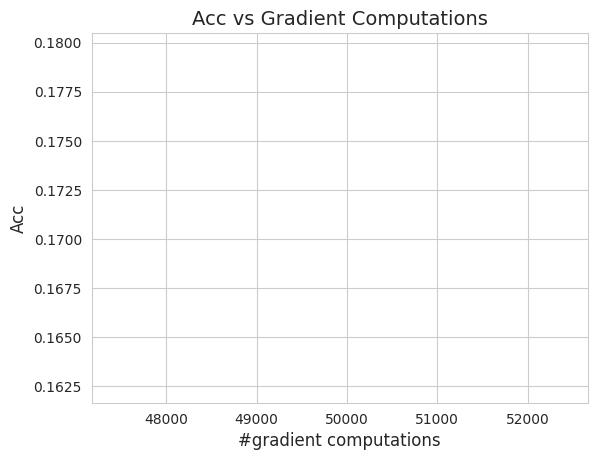

Training: 100%|██████████| 195/195 [00:01<00:00, 116.30it/s, loss=2.1490]
2025-05-23 07:06:26.773127: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2: val_acc=0.21644631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 109.73it/s, loss=2.0169]


Epoch 3: val_acc=0.24419070780277252


Training: 100%|██████████| 195/195 [00:01<00:00, 111.90it/s, loss=1.9216]
2025-05-23 07:06:30.732029: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4: val_acc=0.26312100887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 115.78it/s, loss=1.8497]


Epoch 5: val_acc=0.2806490361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 112.49it/s, loss=1.7890]


Epoch 6: val_acc=0.2912660241127014


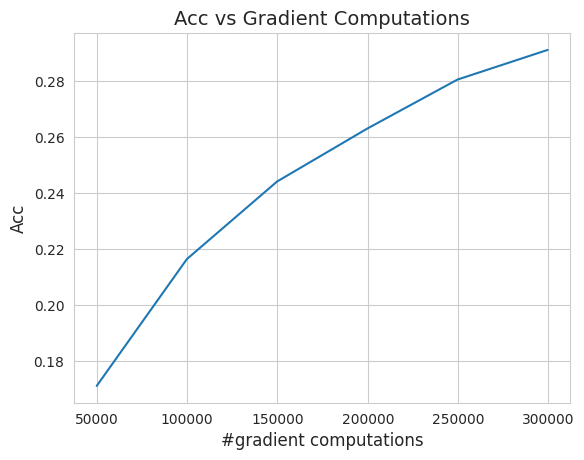

Training: 100%|██████████| 195/195 [00:01<00:00, 112.59it/s, loss=1.7377]


Epoch 7: val_acc=0.29917868971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 111.73it/s, loss=1.6927]
2025-05-23 07:06:38.667654: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8: val_acc=0.3091947138309479


Training: 100%|██████████| 195/195 [00:01<00:00, 110.37it/s, loss=1.6534]


Epoch 9: val_acc=0.31870993971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 114.63it/s, loss=1.6173]


Epoch 10: val_acc=0.32582131028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 117.55it/s, loss=1.5843]


Epoch 11: val_acc=0.33303284645080566


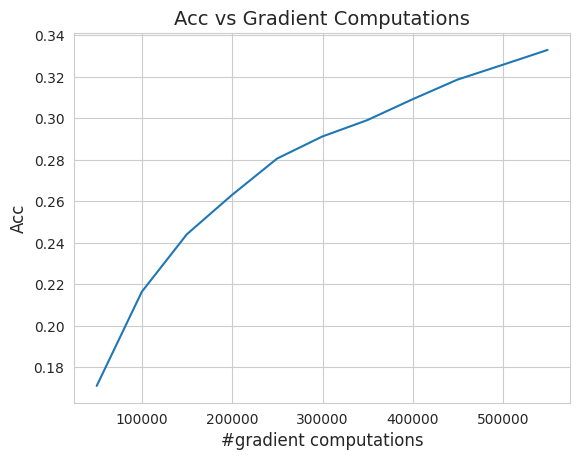

Training: 100%|██████████| 195/195 [00:01<00:00, 111.36it/s, loss=1.5548]


Epoch 12: val_acc=0.33733975887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 111.15it/s, loss=1.5264]


Epoch 13: val_acc=0.3422476053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 112.93it/s, loss=1.5012]


Epoch 14: val_acc=0.34715545177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 112.52it/s, loss=1.4771]


Epoch 15: val_acc=0.35036057233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 114.27it/s, loss=1.4540]


Epoch 16: val_acc=0.35166266560554504


2025-05-23 07:06:54.331281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


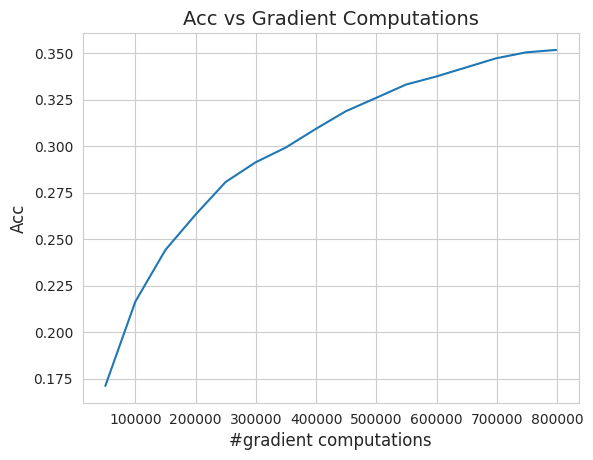

Training: 100%|██████████| 195/195 [00:01<00:00, 109.79it/s, loss=1.4319]


Epoch 17: val_acc=0.35667067766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 113.82it/s, loss=1.4115]


Epoch 18: val_acc=0.3604767620563507


Training: 100%|██████████| 195/195 [00:01<00:00, 112.73it/s, loss=1.3915]


Epoch 19: val_acc=0.36428284645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 112.59it/s, loss=1.3729]


Epoch 20: val_acc=0.36748799681663513


Training: 100%|██████████| 195/195 [00:01<00:00, 112.11it/s, loss=1.3546]


Epoch 21: val_acc=0.3691907227039337


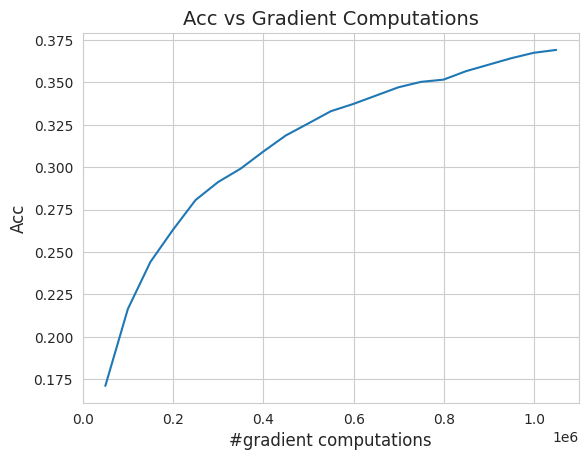

Training: 100%|██████████| 195/195 [00:01<00:00, 112.34it/s, loss=1.3369]


Epoch 22: val_acc=0.37299680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 112.61it/s, loss=1.3199]


Epoch 23: val_acc=0.3756009638309479


Training: 100%|██████████| 195/195 [00:01<00:00, 119.57it/s, loss=1.3033]


Epoch 24: val_acc=0.3781049847602844


Training: 100%|██████████| 195/195 [00:01<00:00, 113.84it/s, loss=1.2874]


Epoch 25: val_acc=0.3809094727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 113.82it/s, loss=1.2720]


Epoch 26: val_acc=0.3824118673801422


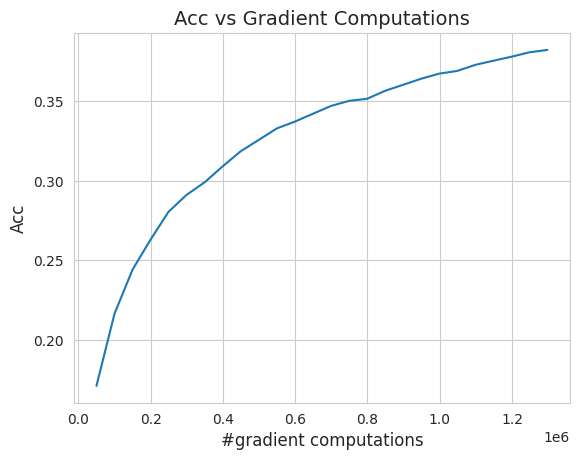

Training: 100%|██████████| 195/195 [00:01<00:00, 108.79it/s, loss=1.2566]


Epoch 27: val_acc=0.38461539149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.43it/s, loss=1.2430]


Epoch 28: val_acc=0.3859174847602844


Training: 100%|██████████| 195/195 [00:01<00:00, 112.22it/s, loss=1.2293]


Epoch 29: val_acc=0.3873197138309479


Training: 100%|██████████| 195/195 [00:01<00:00, 114.66it/s, loss=1.2162]


Epoch 30: val_acc=0.39032453298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 111.11it/s, loss=1.2032]


Epoch 31: val_acc=0.391526460647583


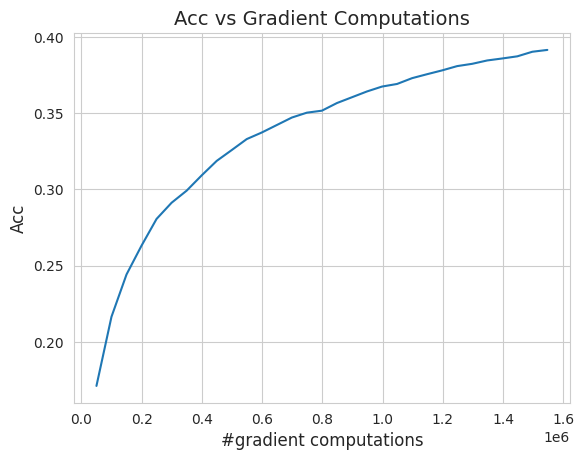

Training: 100%|██████████| 195/195 [00:01<00:00, 113.07it/s, loss=1.1907]
2025-05-23 07:07:26.019871: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32: val_acc=0.3936298191547394


Training: 100%|██████████| 195/195 [00:01<00:00, 111.93it/s, loss=1.1779]


Epoch 33: val_acc=0.3962339758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 112.50it/s, loss=1.1660]


Epoch 34: val_acc=0.3977363705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 114.25it/s, loss=1.1539]


Epoch 35: val_acc=0.39983975887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 110.71it/s, loss=1.1423]


Epoch 36: val_acc=0.4008413553237915


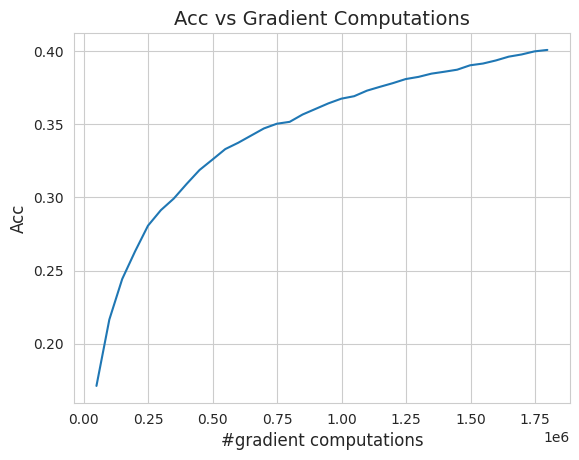

Training: 100%|██████████| 195/195 [00:01<00:00, 113.98it/s, loss=1.1309]


Epoch 37: val_acc=0.40244391560554504


Training: 100%|██████████| 195/195 [00:01<00:00, 113.59it/s, loss=1.1196]


Epoch 38: val_acc=0.4047476053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 113.46it/s, loss=1.1087]


Epoch 39: val_acc=0.40524840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 113.58it/s, loss=1.0978]


Epoch 40: val_acc=0.4058493673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 110.48it/s, loss=1.0872]


Epoch 41: val_acc=0.407151460647583


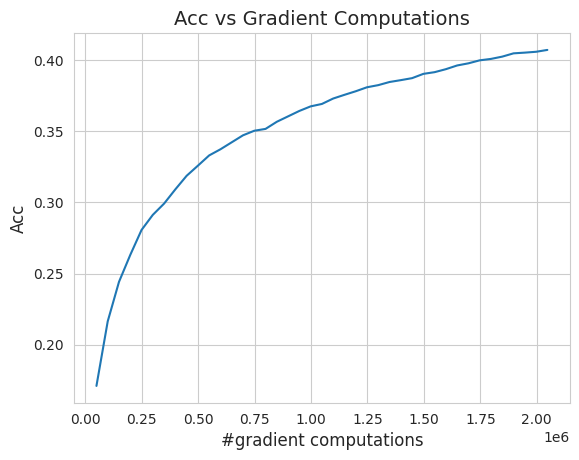

Training: 100%|██████████| 195/195 [00:01<00:00, 113.07it/s, loss=1.0768]


Epoch 42: val_acc=0.40815305709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 118.02it/s, loss=1.0667]


Epoch 43: val_acc=0.40855368971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 111.34it/s, loss=1.0565]


Epoch 44: val_acc=0.4095552861690521


Training: 100%|██████████| 195/195 [00:01<00:00, 110.56it/s, loss=1.0464]


Epoch 45: val_acc=0.4107572138309479


Training: 100%|██████████| 195/195 [00:01<00:00, 114.78it/s, loss=1.0367]


Epoch 46: val_acc=0.4118589758872986


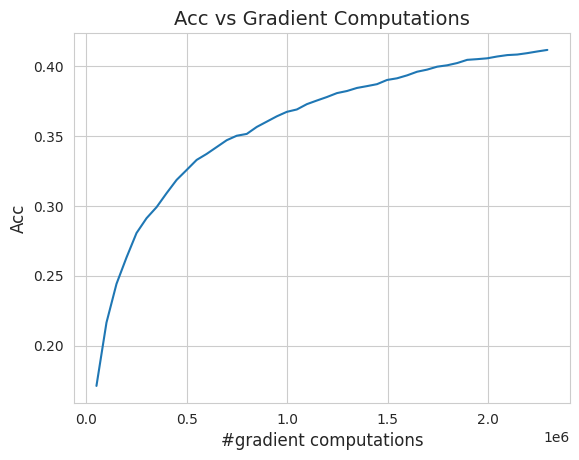

Training: 100%|██████████| 195/195 [00:01<00:00, 114.91it/s, loss=1.0277]


Epoch 47: val_acc=0.41286057233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 113.51it/s, loss=1.0181]


Epoch 48: val_acc=0.41376203298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 116.57it/s, loss=1.0087]


Epoch 49: val_acc=0.4153645932674408


Training: 100%|██████████| 195/195 [00:01<00:00, 112.95it/s, loss=0.9999]


Epoch 50: val_acc=0.41566506028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 119.08it/s, loss=0.9912]


Epoch 51: val_acc=0.41696715354919434


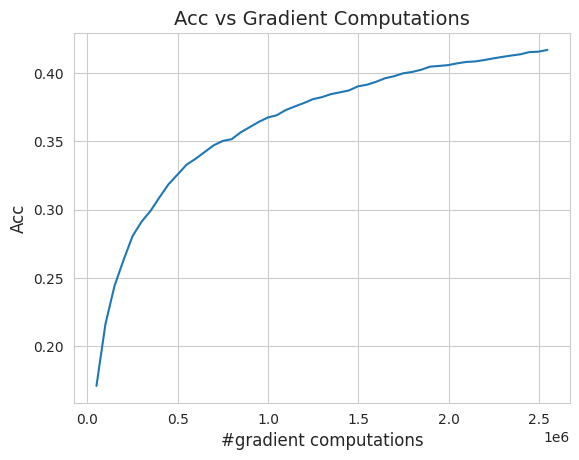

Training: 100%|██████████| 195/195 [00:01<00:00, 112.18it/s, loss=0.9825]


Epoch 52: val_acc=0.41796875


Training: 100%|██████████| 195/195 [00:01<00:00, 115.78it/s, loss=0.9741]


Epoch 53: val_acc=0.4173677861690521


Training: 100%|██████████| 195/195 [00:01<00:00, 112.45it/s, loss=0.9658]


Epoch 54: val_acc=0.41766828298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 118.68it/s, loss=0.9570]


Epoch 55: val_acc=0.41897034645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 117.33it/s, loss=0.9492]


Epoch 56: val_acc=0.41987180709838867


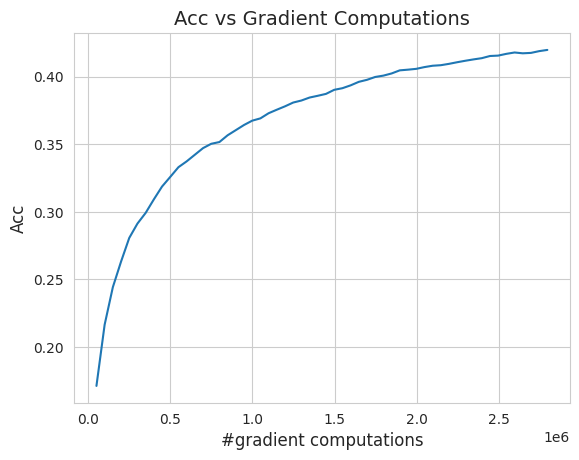

Training: 100%|██████████| 195/195 [00:01<00:00, 111.63it/s, loss=0.9411]


Epoch 57: val_acc=0.4207732379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 110.97it/s, loss=0.9332]


Epoch 58: val_acc=0.4211738705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 113.60it/s, loss=0.9251]


Epoch 59: val_acc=0.42217549681663513


Training: 100%|██████████| 195/195 [00:01<00:00, 112.52it/s, loss=0.9172]


Epoch 60: val_acc=0.4220753312110901


Training: 100%|██████████| 195/195 [00:01<00:00, 115.73it/s, loss=0.9099]


Epoch 61: val_acc=0.42267629504203796


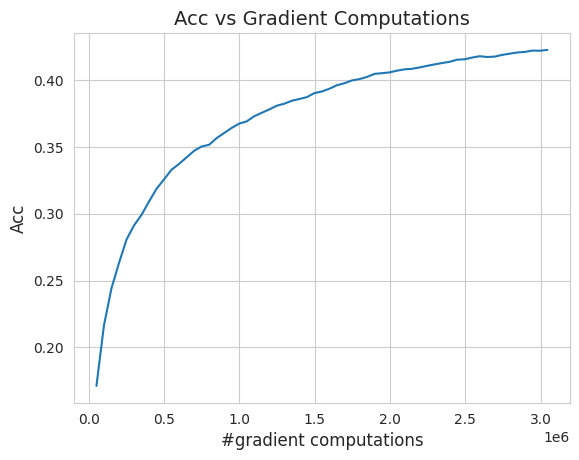

Training: 100%|██████████| 195/195 [00:01<00:00, 114.40it/s, loss=0.9021]


Epoch 62: val_acc=0.42287659645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 111.89it/s, loss=0.8946]


Epoch 63: val_acc=0.42367789149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 109.23it/s, loss=0.8874]
2025-05-23 07:08:28.657671: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64: val_acc=0.42417868971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 112.41it/s, loss=0.8798]


Epoch 65: val_acc=0.4246794879436493


Training: 100%|██████████| 195/195 [00:01<00:00, 112.86it/s, loss=0.8727]


Epoch 66: val_acc=0.42528045177459717


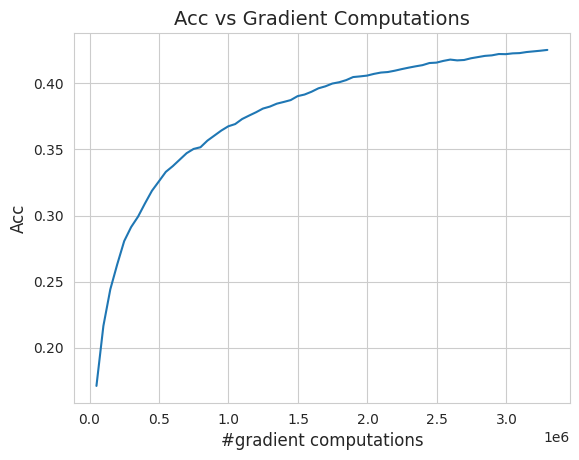

Training: 100%|██████████| 195/195 [00:01<00:00, 109.47it/s, loss=0.8655]


Epoch 67: val_acc=0.42568108439445496


Training: 100%|██████████| 195/195 [00:01<00:00, 114.30it/s, loss=0.8581]


Epoch 68: val_acc=0.42568108439445496


Training: 100%|██████████| 195/195 [00:01<00:00, 116.59it/s, loss=0.8510]


Epoch 69: val_acc=0.4253806173801422


Training: 100%|██████████| 195/195 [00:01<00:00, 112.34it/s, loss=0.8436]


Epoch 70: val_acc=0.4264823794364929


Training: 100%|██████████| 195/195 [00:01<00:00, 114.71it/s, loss=0.8368]


Epoch 71: val_acc=0.42718350887298584


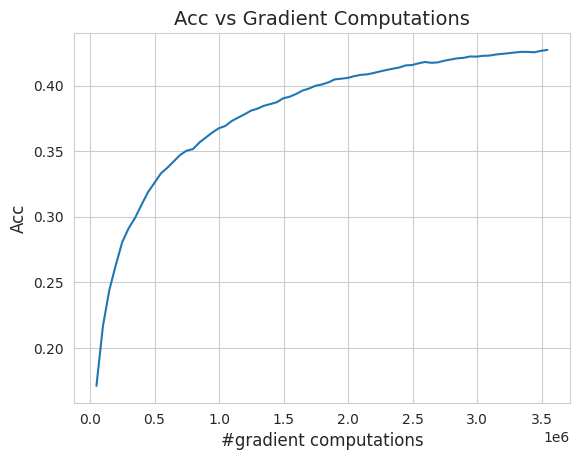

Training: 100%|██████████| 195/195 [00:01<00:00, 110.26it/s, loss=0.8298]


Epoch 72: val_acc=0.42678284645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 110.06it/s, loss=0.8228]


Epoch 73: val_acc=0.4272836446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 112.97it/s, loss=0.8157]


Epoch 74: val_acc=0.4274839758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 115.64it/s, loss=0.8087]


Epoch 75: val_acc=0.42788460850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 118.35it/s, loss=0.8022]


Epoch 76: val_acc=0.4281851053237915


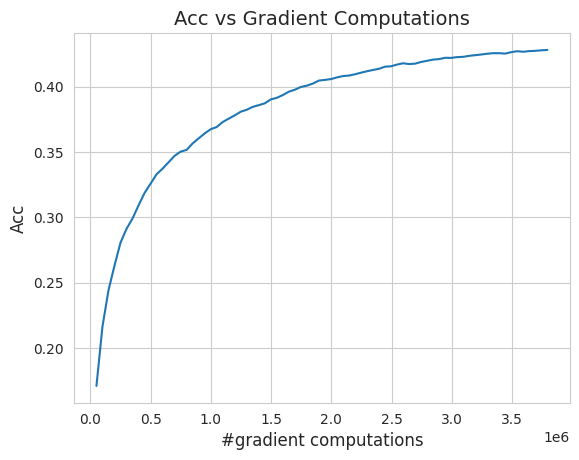

Training: 100%|██████████| 195/195 [00:01<00:00, 109.36it/s, loss=0.7950]


Epoch 77: val_acc=0.42788460850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 109.66it/s, loss=0.7881]


Epoch 78: val_acc=0.42868590354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 108.81it/s, loss=0.7812]


Epoch 79: val_acc=0.4288862347602844


Training: 100%|██████████| 195/195 [00:01<00:00, 113.04it/s, loss=0.7745]


Epoch 80: val_acc=0.4296875


Training: 100%|██████████| 195/195 [00:01<00:00, 116.36it/s, loss=0.7675]


Epoch 81: val_acc=0.42868590354919434


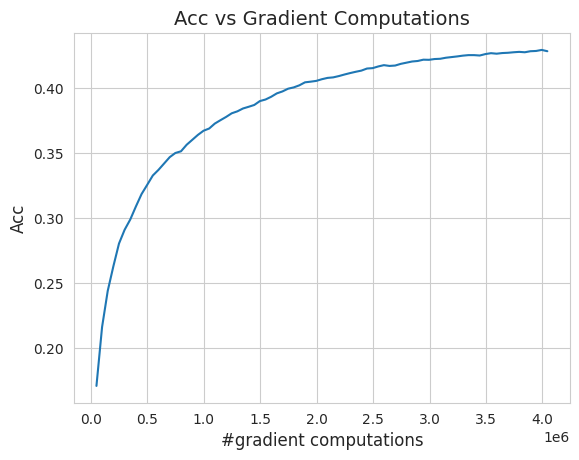

Training: 100%|██████████| 195/195 [00:01<00:00, 111.96it/s, loss=0.7608]


Epoch 82: val_acc=0.4290865361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 115.18it/s, loss=0.7542]


Epoch 83: val_acc=0.4294871985912323


Training: 100%|██████████| 195/195 [00:01<00:00, 112.42it/s, loss=0.7479]


Epoch 84: val_acc=0.4296875


Training: 100%|██████████| 195/195 [00:01<00:00, 111.19it/s, loss=0.7413]


Epoch 85: val_acc=0.43018829822540283


Training: 100%|██████████| 195/195 [00:01<00:00, 119.48it/s, loss=0.7349]


Epoch 86: val_acc=0.4302884638309479


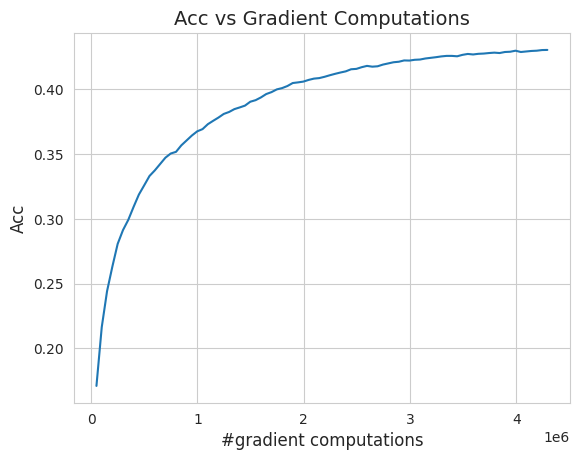

Training: 100%|██████████| 195/195 [00:01<00:00, 118.47it/s, loss=0.7279]


Epoch 87: val_acc=0.430588960647583


Training: 100%|██████████| 195/195 [00:01<00:00, 113.19it/s, loss=0.7221]


Epoch 88: val_acc=0.43048879504203796


Training: 100%|██████████| 195/195 [00:01<00:00, 123.36it/s, loss=0.7151]


Epoch 89: val_acc=0.4302884638309479


Training: 100%|██████████| 195/195 [00:01<00:00, 110.16it/s, loss=0.7088]


Epoch 90: val_acc=0.43018829822540283


Training: 100%|██████████| 195/195 [00:01<00:00, 112.56it/s, loss=0.7022]


Epoch 91: val_acc=0.4307892620563507


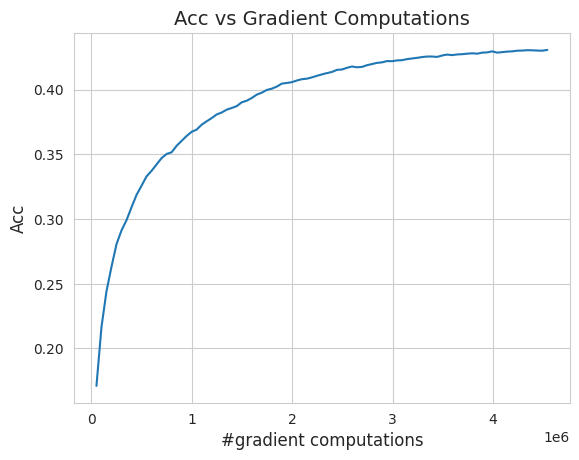

Training: 100%|██████████| 195/195 [00:01<00:00, 109.90it/s, loss=0.6960]


Epoch 92: val_acc=0.43129006028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 110.78it/s, loss=0.6893]


Epoch 93: val_acc=0.4313902258872986


Training: 100%|██████████| 195/195 [00:01<00:00, 117.28it/s, loss=0.6831]


Epoch 94: val_acc=0.4307892620563507


Training: 100%|██████████| 195/195 [00:01<00:00, 111.70it/s, loss=0.6766]


Epoch 95: val_acc=0.43129006028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 113.39it/s, loss=0.6704]


Epoch 96: val_acc=0.43179085850715637


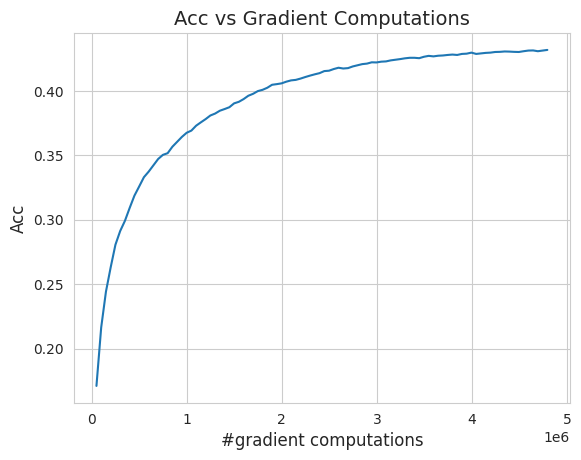

Training: 100%|██████████| 195/195 [00:01<00:00, 113.35it/s, loss=0.6644]


Epoch 97: val_acc=0.43149039149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.67it/s, loss=0.6579]


Epoch 98: val_acc=0.43149039149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.07it/s, loss=0.6519]


Epoch 99: val_acc=0.4318910241127014


Training: 100%|██████████| 195/195 [00:01<00:00, 113.56it/s, loss=0.6457]


Epoch 100: val_acc=0.4320913553237915


Training: 100%|██████████| 195/195 [00:01<00:00, 114.88it/s, loss=0.6396]


Epoch 101: val_acc=0.43219152092933655


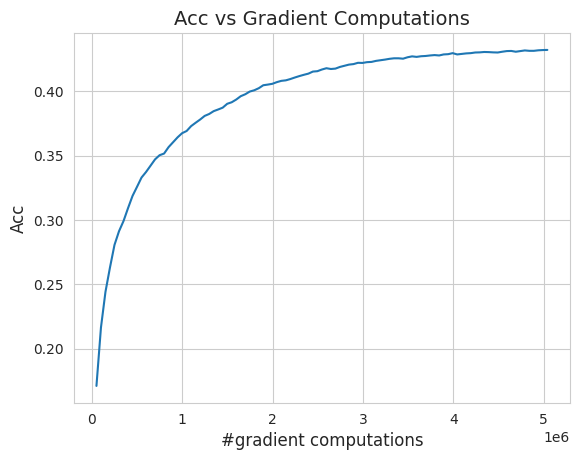

Training: 100%|██████████| 195/195 [00:01<00:00, 110.43it/s, loss=0.6334]


Epoch 102: val_acc=0.43239182233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 108.55it/s, loss=0.6275]


Epoch 103: val_acc=0.4322916865348816


Training: 100%|██████████| 195/195 [00:01<00:00, 110.51it/s, loss=0.6214]


Epoch 104: val_acc=0.4326923191547394


Training: 100%|██████████| 195/195 [00:01<00:00, 112.70it/s, loss=0.6154]


Epoch 105: val_acc=0.4327924847602844


Training: 100%|██████████| 195/195 [00:01<00:00, 115.28it/s, loss=0.6095]


Epoch 106: val_acc=0.4329927861690521


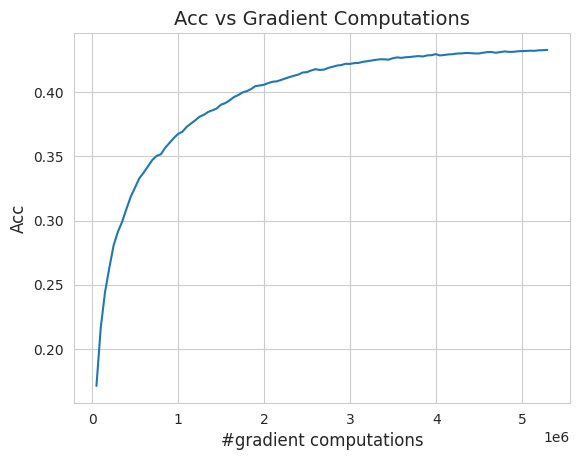

Training: 100%|██████████| 195/195 [00:01<00:00, 109.66it/s, loss=0.6036]


Epoch 107: val_acc=0.43329328298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 109.20it/s, loss=0.5976]


Epoch 108: val_acc=0.43329328298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 111.98it/s, loss=0.5918]


Epoch 109: val_acc=0.43349358439445496


Training: 100%|██████████| 195/195 [00:01<00:00, 110.65it/s, loss=0.5859]


Epoch 110: val_acc=0.43359375


Training: 100%|██████████| 195/195 [00:01<00:00, 110.72it/s, loss=0.5798]


Epoch 111: val_acc=0.4337940812110901


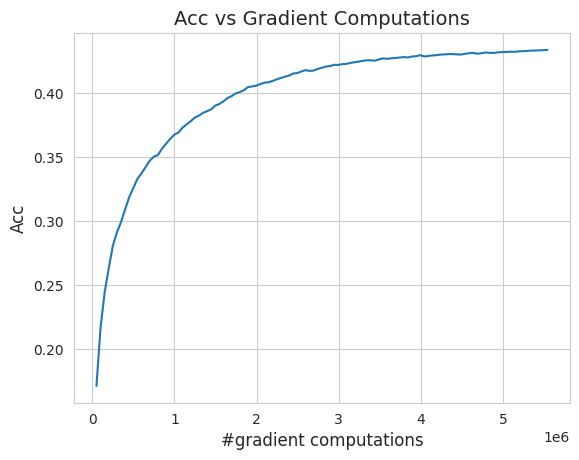

Training: 100%|██████████| 195/195 [00:01<00:00, 112.52it/s, loss=0.5739]


Epoch 112: val_acc=0.43409454822540283


Training: 100%|██████████| 195/195 [00:01<00:00, 109.56it/s, loss=0.5685]


Epoch 113: val_acc=0.4341947138309479


Training: 100%|██████████| 195/195 [00:01<00:00, 112.25it/s, loss=0.5631]


Epoch 114: val_acc=0.4342948794364929


Training: 100%|██████████| 195/195 [00:01<00:00, 113.10it/s, loss=0.5573]


Epoch 115: val_acc=0.43409454822540283


Training: 100%|██████████| 195/195 [00:01<00:00, 114.14it/s, loss=0.5516]


Epoch 116: val_acc=0.4342948794364929


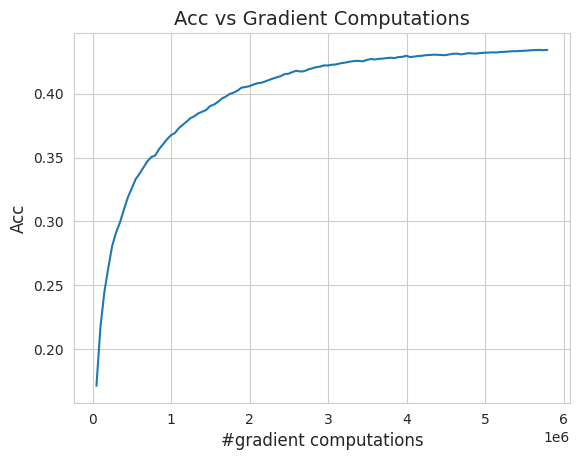

Training: 100%|██████████| 195/195 [00:01<00:00, 111.91it/s, loss=0.5460]


Epoch 117: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 113.77it/s, loss=0.5407]


Epoch 118: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 108.60it/s, loss=0.5357]


Epoch 119: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 113.49it/s, loss=0.5301]


Epoch 120: val_acc=0.4341947138309479


Training: 100%|██████████| 195/195 [00:01<00:00, 112.49it/s, loss=0.5247]


Epoch 121: val_acc=0.43479567766189575


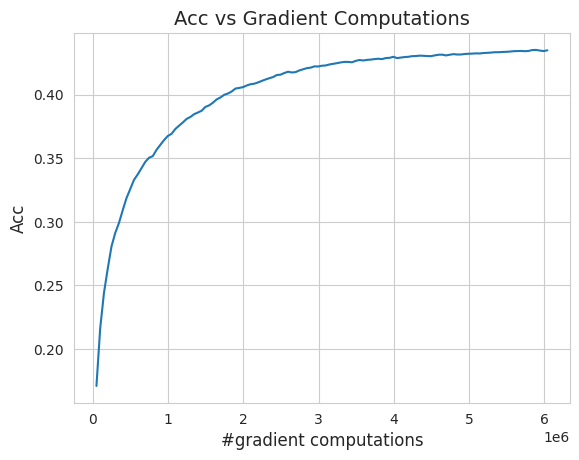

Training: 100%|██████████| 195/195 [00:01<00:00, 114.52it/s, loss=0.5191]


Epoch 122: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 114.40it/s, loss=0.5139]


Epoch 123: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 107.98it/s, loss=0.5084]


Epoch 124: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 116.69it/s, loss=0.5033]


Epoch 125: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 114.05it/s, loss=0.4981]


Epoch 126: val_acc=0.4352964758872986


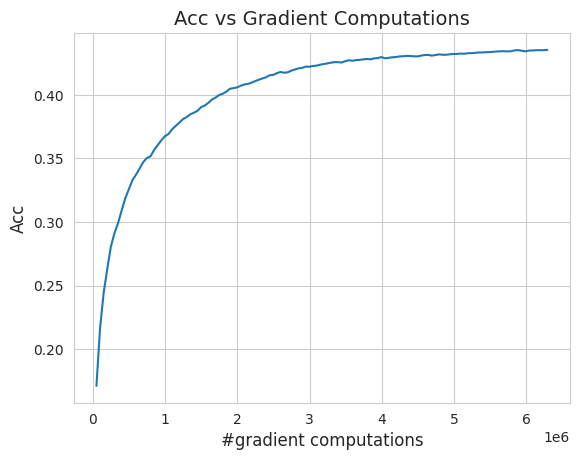

Training: 100%|██████████| 195/195 [00:01<00:00, 115.96it/s, loss=0.4930]


Epoch 127: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 111.92it/s, loss=0.4875]
2025-05-23 07:10:35.224836: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 112.71it/s, loss=0.4824]


Epoch 129: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 112.95it/s, loss=0.4775]


Epoch 130: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 119.30it/s, loss=0.4725]


Epoch 131: val_acc=0.4355969727039337


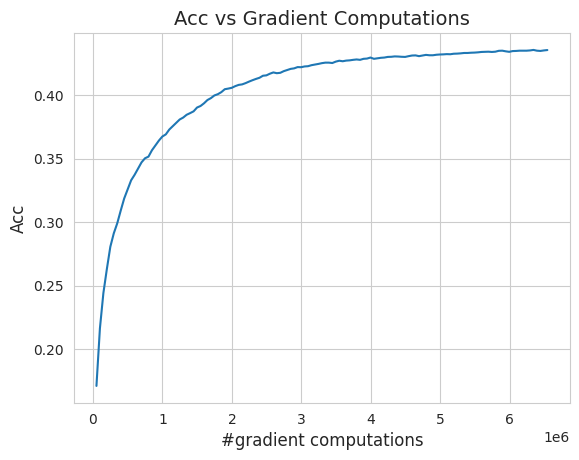

Training: 100%|██████████| 195/195 [00:01<00:00, 112.99it/s, loss=0.4674]


Epoch 132: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 110.68it/s, loss=0.4620]


Epoch 133: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 114.22it/s, loss=0.4575]


Epoch 134: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 113.59it/s, loss=0.4523]


Epoch 135: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 112.56it/s, loss=0.4473]


Epoch 136: val_acc=0.43549680709838867


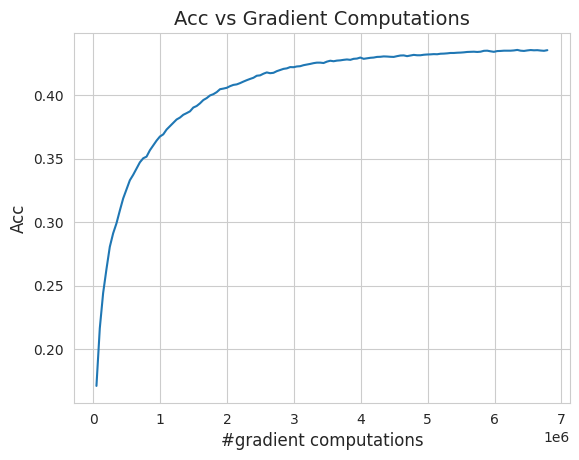

Training: 100%|██████████| 195/195 [00:01<00:00, 114.77it/s, loss=0.4425]


Epoch 137: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 109.58it/s, loss=0.4376]


Epoch 138: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 110.29it/s, loss=0.4327]


Epoch 139: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 111.64it/s, loss=0.4282]


Epoch 140: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 110.36it/s, loss=0.4235]


Epoch 141: val_acc=0.43609777092933655


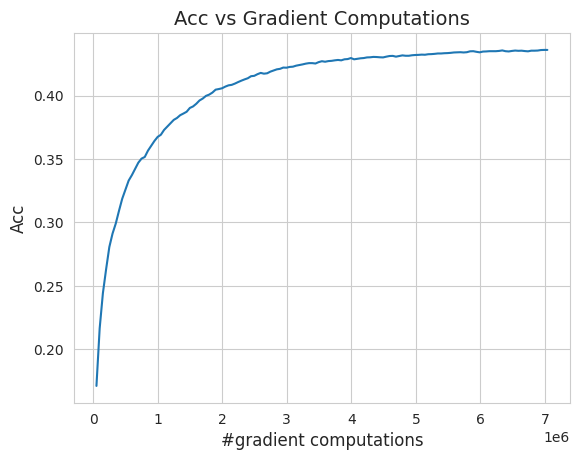

Training: 100%|██████████| 195/195 [00:01<00:00, 111.49it/s, loss=0.4190]


Epoch 142: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 113.50it/s, loss=0.4143]


Epoch 143: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 121.85it/s, loss=0.4097]


Epoch 144: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 116.32it/s, loss=0.4049]


Epoch 145: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 112.80it/s, loss=0.4003]


Epoch 146: val_acc=0.4365985691547394


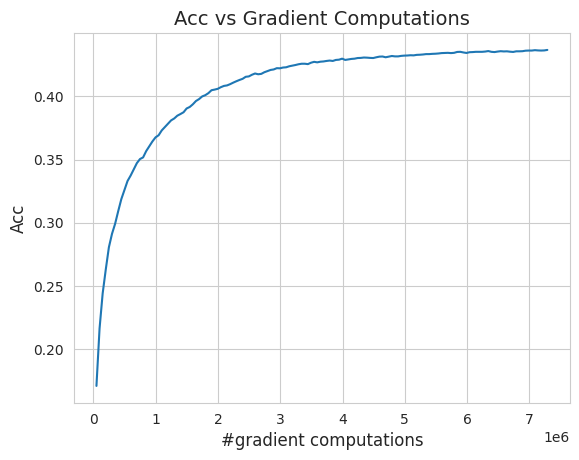

Training: 100%|██████████| 195/195 [00:01<00:00, 112.26it/s, loss=0.3958]


Epoch 147: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 116.45it/s, loss=0.3914]


Epoch 148: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 108.21it/s, loss=0.3869]


Epoch 149: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 114.90it/s, loss=0.3826]


Epoch 150: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 112.25it/s, loss=0.3783]


Epoch 151: val_acc=0.4368990361690521


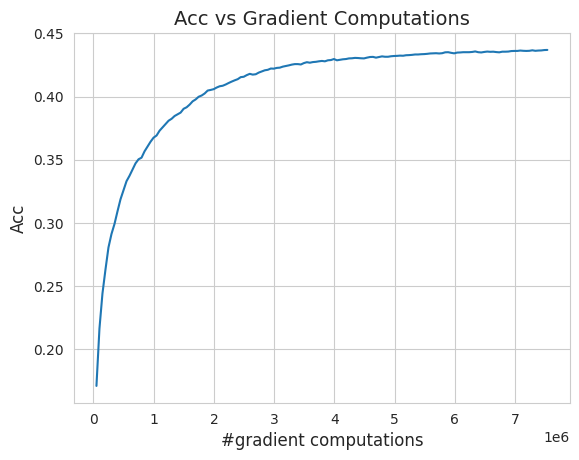

Training: 100%|██████████| 195/195 [00:01<00:00, 116.17it/s, loss=0.3737]


Epoch 152: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 109.95it/s, loss=0.3696]


Epoch 153: val_acc=0.43589743971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 118.48it/s, loss=0.3654]


Epoch 154: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 111.47it/s, loss=0.3607]


Epoch 155: val_acc=0.4375


Training: 100%|██████████| 195/195 [00:01<00:00, 111.25it/s, loss=0.3566]


Epoch 156: val_acc=0.43699920177459717


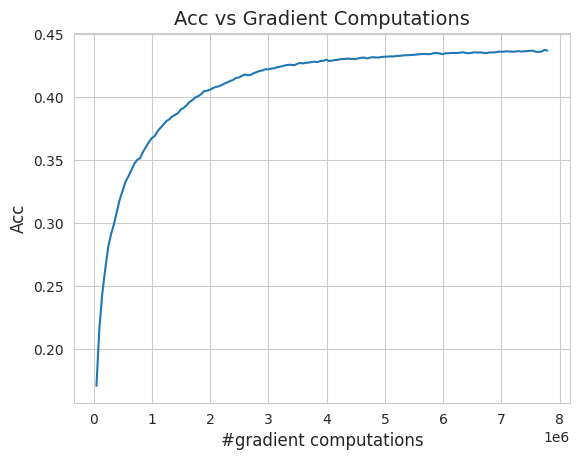

Training: 100%|██████████| 195/195 [00:01<00:00, 108.52it/s, loss=0.3525]


Epoch 157: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 117.32it/s, loss=0.3481]


Epoch 158: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 112.32it/s, loss=0.3442]


Epoch 159: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 110.66it/s, loss=0.3401]


Epoch 160: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 109.86it/s, loss=0.3360]


Epoch 161: val_acc=0.4368990361690521


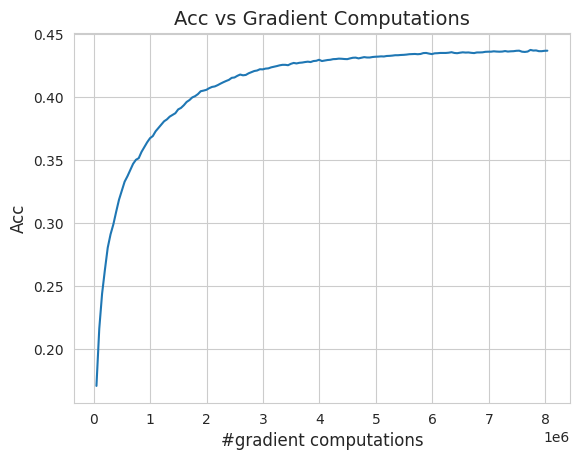

Training: 100%|██████████| 195/195 [00:01<00:00, 111.97it/s, loss=0.3318]


Epoch 162: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 117.02it/s, loss=0.3279]


Epoch 163: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 114.41it/s, loss=0.3241]


Epoch 164: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 111.80it/s, loss=0.3199]


Epoch 165: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 111.23it/s, loss=0.3164]


Epoch 166: val_acc=0.43589743971824646


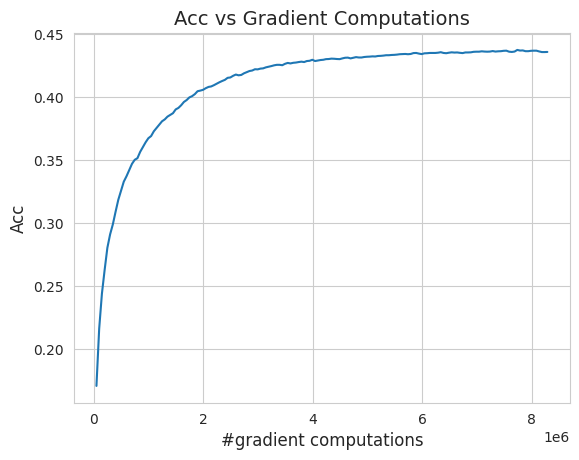

Training: 100%|██████████| 195/195 [00:01<00:00, 112.14it/s, loss=0.3125]


Epoch 167: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.88it/s, loss=0.3088]


Epoch 168: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 112.88it/s, loss=0.3050]


Epoch 169: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 111.92it/s, loss=0.3012]


Epoch 170: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 113.98it/s, loss=0.2976]


Epoch 171: val_acc=0.4359976053237915


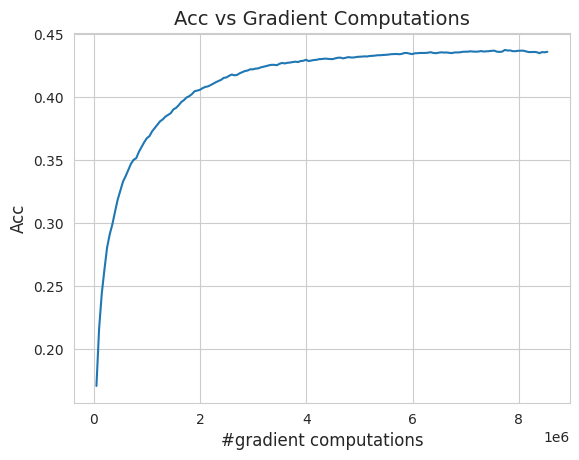

Training: 100%|██████████| 195/195 [00:01<00:00, 112.76it/s, loss=0.2939]


Epoch 172: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 114.40it/s, loss=0.2903]


Epoch 173: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 112.29it/s, loss=0.2867]


Epoch 174: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 115.80it/s, loss=0.2831]


Epoch 175: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 112.11it/s, loss=0.2795]


Epoch 176: val_acc=0.4363982379436493


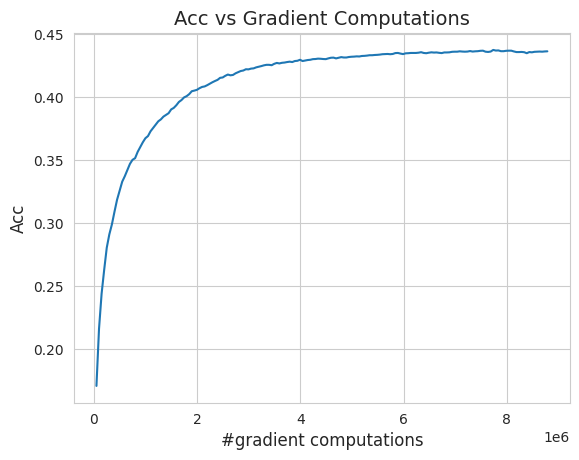

Training: 100%|██████████| 195/195 [00:01<00:00, 111.64it/s, loss=0.2760]


Epoch 177: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 111.44it/s, loss=0.2726]


Epoch 178: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 113.49it/s, loss=0.2692]


Epoch 179: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 115.32it/s, loss=0.2660]


Epoch 180: val_acc=0.4366987347602844


Training: 100%|██████████| 195/195 [00:01<00:00, 111.97it/s, loss=0.2627]


Epoch 181: val_acc=0.43649840354919434


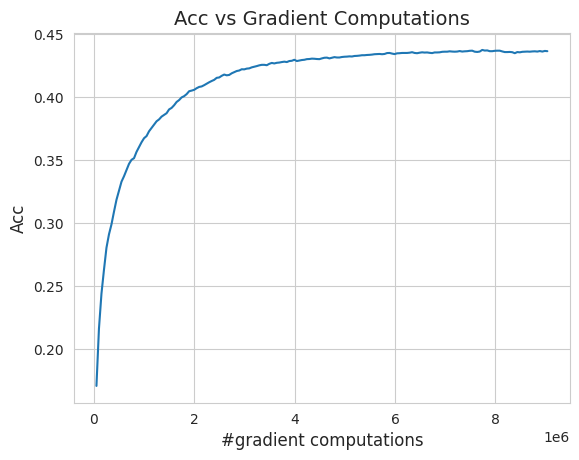

Training: 100%|██████████| 195/195 [00:01<00:00, 116.25it/s, loss=0.2593]


Epoch 182: val_acc=0.43739983439445496


Training: 100%|██████████| 195/195 [00:01<00:00, 111.47it/s, loss=0.2560]


Epoch 183: val_acc=0.4372996985912323


Training: 100%|██████████| 195/195 [00:01<00:00, 111.61it/s, loss=0.2528]


Epoch 184: val_acc=0.4372996985912323


Training: 100%|██████████| 195/195 [00:01<00:00, 116.65it/s, loss=0.2496]


Epoch 185: val_acc=0.4375


Training: 100%|██████████| 195/195 [00:01<00:00, 112.54it/s, loss=0.2466]


Epoch 186: val_acc=0.43719953298568726


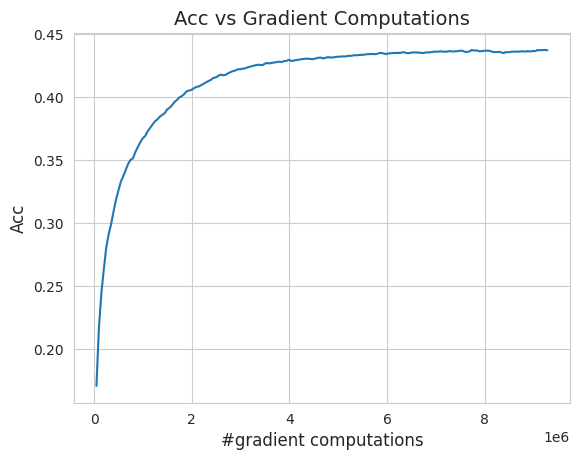

Training: 100%|██████████| 195/195 [00:01<00:00, 110.69it/s, loss=0.2436]


Epoch 187: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 117.22it/s, loss=0.2403]


Epoch 188: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 113.05it/s, loss=0.2374]


Epoch 189: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 113.52it/s, loss=0.2343]


Epoch 190: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 111.32it/s, loss=0.2315]


Epoch 191: val_acc=0.4372996985912323


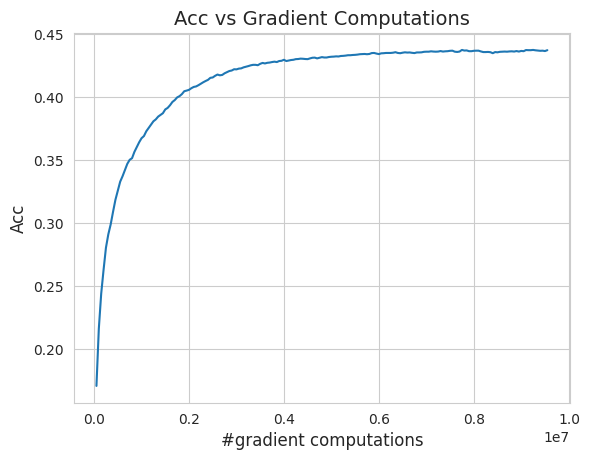

Training: 100%|██████████| 195/195 [00:01<00:00, 113.77it/s, loss=0.2286]


Epoch 192: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 112.55it/s, loss=0.2259]


Epoch 193: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 117.99it/s, loss=0.2229]


Epoch 194: val_acc=0.4366987347602844


Training: 100%|██████████| 195/195 [00:01<00:00, 108.37it/s, loss=0.2202]


Epoch 195: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 110.79it/s, loss=0.2173]


Epoch 196: val_acc=0.4367988705635071


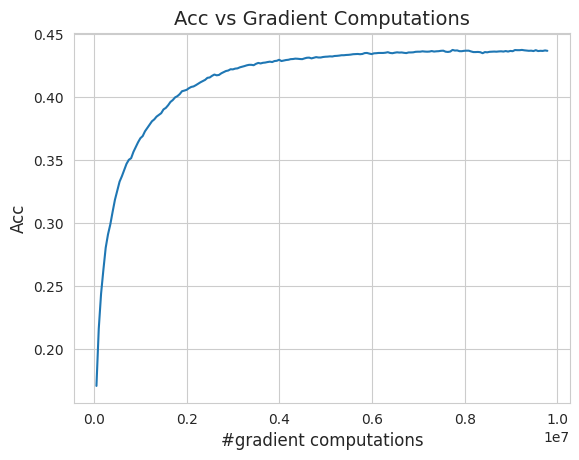

Training: 100%|██████████| 195/195 [00:01<00:00, 114.67it/s, loss=0.2145]


Epoch 197: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 115.77it/s, loss=0.2121]


Epoch 198: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 111.37it/s, loss=0.2093]


Epoch 199: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 109.09it/s, loss=0.2068]


Epoch 200: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 117.64it/s, loss=0.2042]


Epoch 201: val_acc=0.43609777092933655


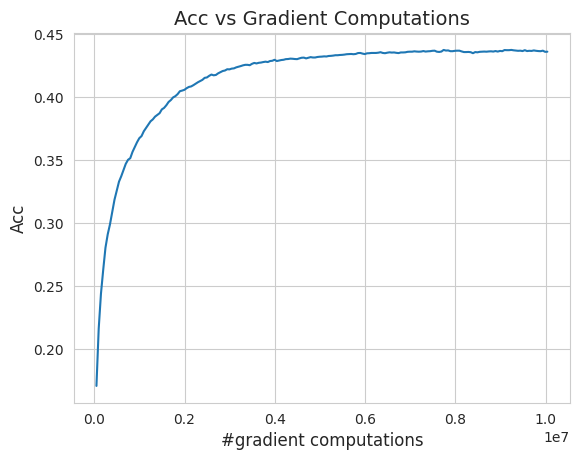

Training: 100%|██████████| 195/195 [00:01<00:00, 112.06it/s, loss=0.2015]


Epoch 202: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 111.42it/s, loss=0.1990]


Epoch 203: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 113.71it/s, loss=0.1965]


Epoch 204: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 116.32it/s, loss=0.1940]


Epoch 205: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 111.73it/s, loss=0.1914]


Epoch 206: val_acc=0.4361979365348816


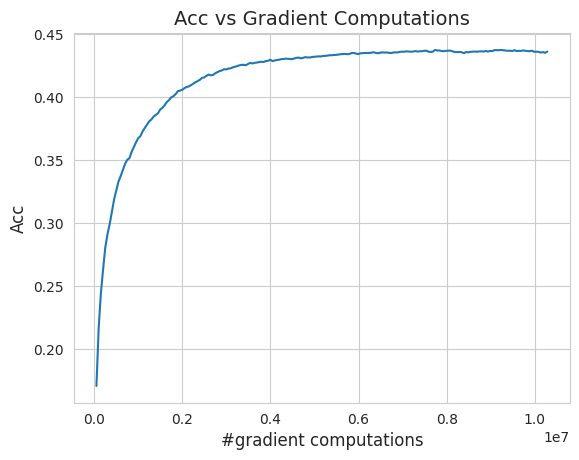

Training: 100%|██████████| 195/195 [00:01<00:00, 114.76it/s, loss=0.1892]


Epoch 207: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 117.46it/s, loss=0.1868]


Epoch 208: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 113.42it/s, loss=0.1845]


Epoch 209: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 112.27it/s, loss=0.1822]


Epoch 210: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 111.40it/s, loss=0.1800]


Epoch 211: val_acc=0.4361979365348816


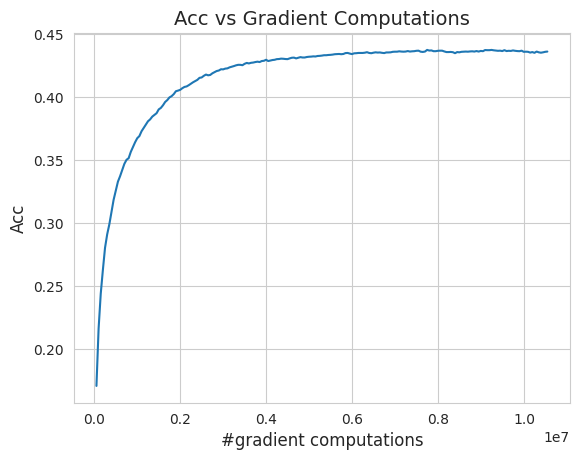

Training: 100%|██████████| 195/195 [00:01<00:00, 111.02it/s, loss=0.1775]


Epoch 212: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 114.81it/s, loss=0.1752]


Epoch 213: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 114.06it/s, loss=0.1733]


Epoch 214: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 118.39it/s, loss=0.1711]


Epoch 215: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 118.45it/s, loss=0.1689]


Epoch 216: val_acc=0.4359976053237915


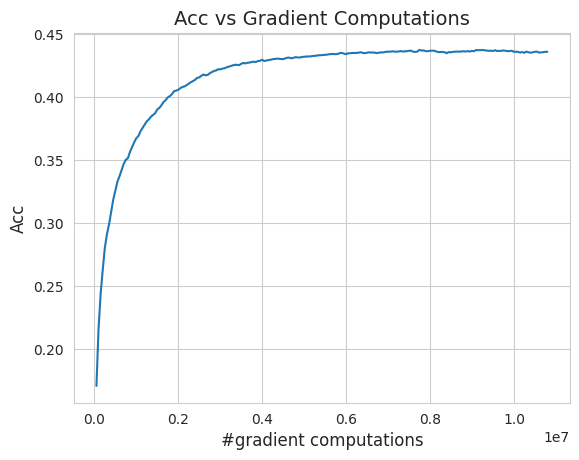

Training: 100%|██████████| 195/195 [00:01<00:00, 111.47it/s, loss=0.1667]


Epoch 217: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 113.07it/s, loss=0.1646]


Epoch 218: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 110.65it/s, loss=0.1625]


Epoch 219: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 111.29it/s, loss=0.1605]


Epoch 220: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 116.49it/s, loss=0.1585]


Epoch 221: val_acc=0.4357972741127014


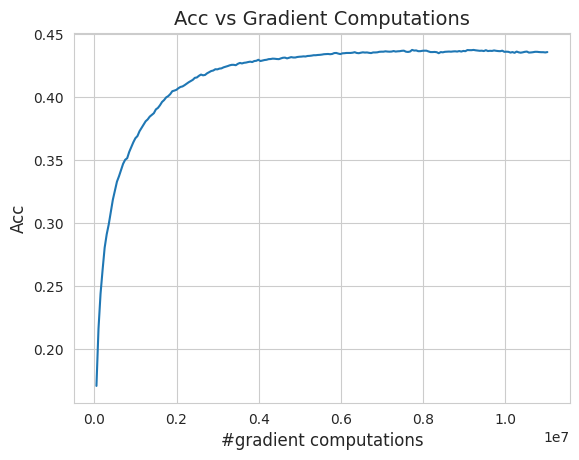

Training: 100%|██████████| 195/195 [00:01<00:00, 112.12it/s, loss=0.1565]


Epoch 222: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 117.34it/s, loss=0.1544]


Epoch 223: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 111.79it/s, loss=0.1526]


Epoch 224: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 108.34it/s, loss=0.1507]


Epoch 225: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 114.09it/s, loss=0.1489]


Epoch 226: val_acc=0.4357972741127014


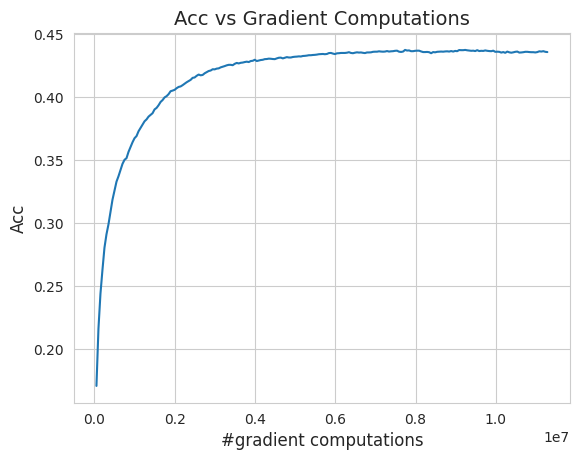

Training: 100%|██████████| 195/195 [00:01<00:00, 112.40it/s, loss=0.1471]


Epoch 227: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 111.03it/s, loss=0.1453]


Epoch 228: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 115.95it/s, loss=0.1433]


Epoch 229: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 111.56it/s, loss=0.1416]


Epoch 230: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 113.55it/s, loss=0.1399]


Epoch 231: val_acc=0.4363982379436493


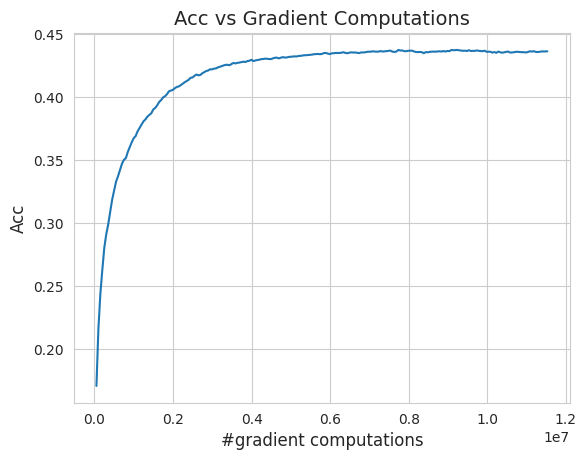

Training: 100%|██████████| 195/195 [00:01<00:00, 115.61it/s, loss=0.1382]


Epoch 232: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 113.58it/s, loss=0.1365]


Epoch 233: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 109.76it/s, loss=0.1349]


Epoch 234: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 111.62it/s, loss=0.1331]


Epoch 235: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 112.39it/s, loss=0.1314]


Epoch 236: val_acc=0.43649840354919434


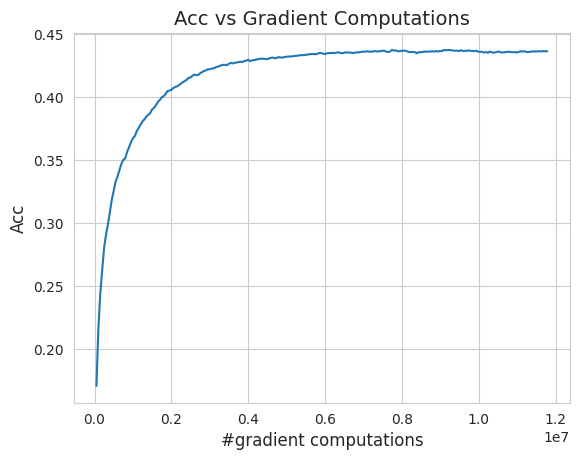

Training: 100%|██████████| 195/195 [00:01<00:00, 112.38it/s, loss=0.1299]


Epoch 237: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 116.94it/s, loss=0.1284]


Epoch 238: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 113.55it/s, loss=0.1267]


Epoch 239: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 110.64it/s, loss=0.1254]


Epoch 240: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 112.88it/s, loss=0.1238]


Epoch 241: val_acc=0.43699920177459717


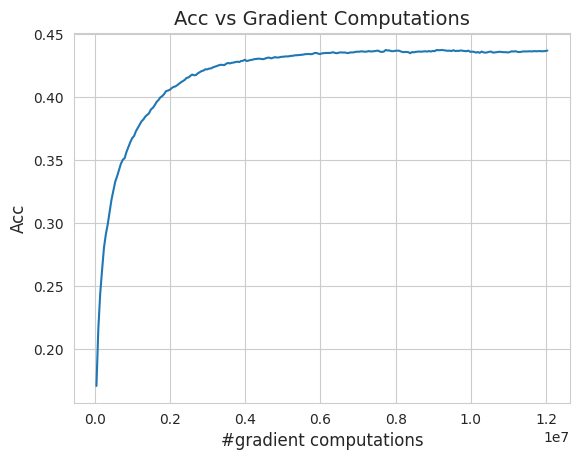

Training: 100%|██████████| 195/195 [00:01<00:00, 111.86it/s, loss=0.1223]


Epoch 242: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 115.18it/s, loss=0.1209]


Epoch 243: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 115.17it/s, loss=0.1194]


Epoch 244: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 120.99it/s, loss=0.1180]


Epoch 245: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 114.54it/s, loss=0.1165]


Epoch 246: val_acc=0.4367988705635071


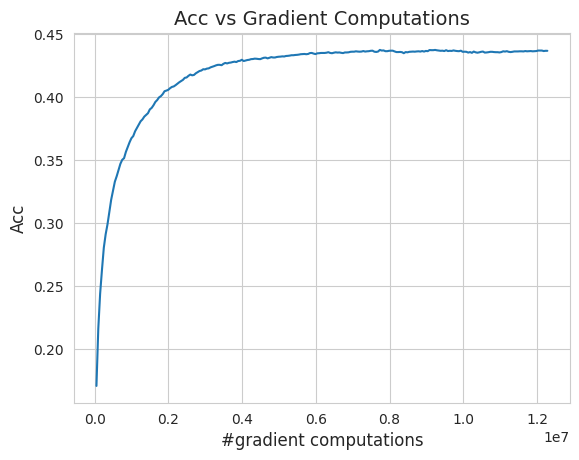

Training: 100%|██████████| 195/195 [00:01<00:00, 112.65it/s, loss=0.1152]


Epoch 247: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 109.82it/s, loss=0.1138]


Epoch 248: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 112.85it/s, loss=0.1124]


Epoch 249: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 116.56it/s, loss=0.1111]


Epoch 250: val_acc=0.4372996985912323


Training: 100%|██████████| 195/195 [00:01<00:00, 118.38it/s, loss=0.1098]


Epoch 251: val_acc=0.4367988705635071


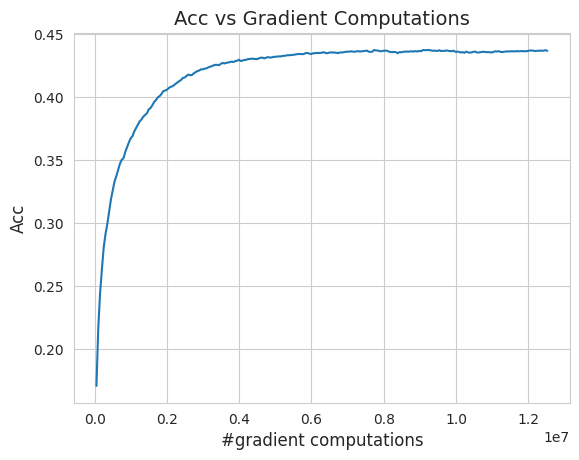

Training: 100%|██████████| 195/195 [00:01<00:00, 112.92it/s, loss=0.1086]


Epoch 252: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 113.41it/s, loss=0.1074]


Epoch 253: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 113.60it/s, loss=0.1062]


Epoch 254: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 114.87it/s, loss=0.1049]


Epoch 255: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 111.14it/s, loss=0.1037]


Epoch 256: val_acc=0.4368990361690521


2025-05-23 07:14:47.045335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


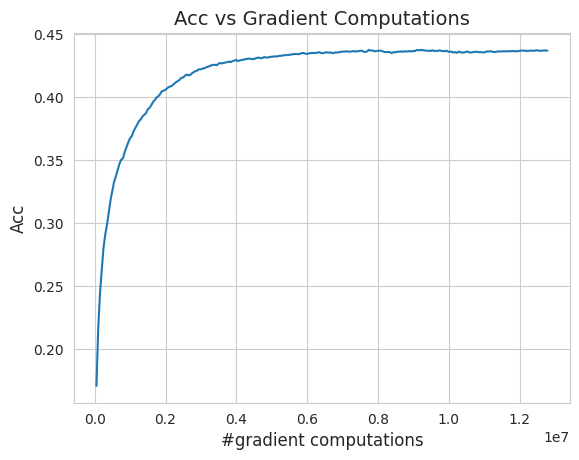

Training: 100%|██████████| 195/195 [00:01<00:00, 111.21it/s, loss=0.1026]


Epoch 257: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 113.18it/s, loss=0.1013]


Epoch 258: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 112.26it/s, loss=0.1001]


Epoch 259: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 113.02it/s, loss=0.0991]


Epoch 260: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 115.69it/s, loss=0.0980]


Epoch 261: val_acc=0.4366987347602844


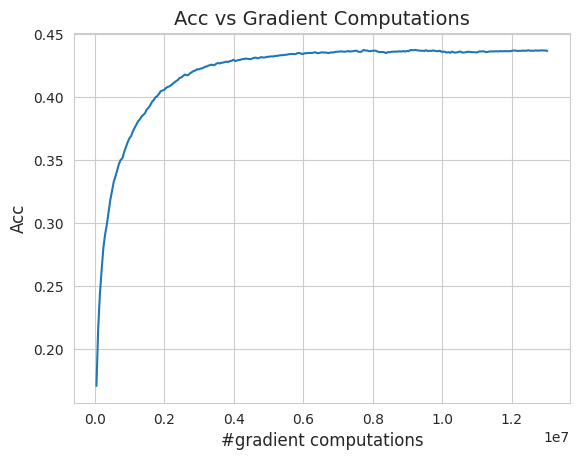

Training: 100%|██████████| 195/195 [00:01<00:00, 112.23it/s, loss=0.0969]


Epoch 262: val_acc=0.43719953298568726


Training: 100%|██████████| 195/195 [00:01<00:00, 109.88it/s, loss=0.0958]


Epoch 263: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 117.03it/s, loss=0.0946]


Epoch 264: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 112.31it/s, loss=0.0936]


Epoch 265: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 109.39it/s, loss=0.0926]


Epoch 266: val_acc=0.43629807233810425


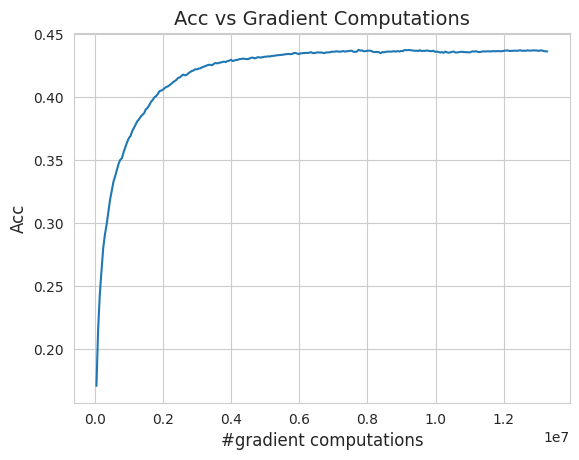

Training: 100%|██████████| 195/195 [00:01<00:00, 110.78it/s, loss=0.0916]


Epoch 267: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 113.02it/s, loss=0.0907]


Epoch 268: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 114.88it/s, loss=0.0896]


Epoch 269: val_acc=0.4366987347602844


Training: 100%|██████████| 195/195 [00:01<00:00, 114.34it/s, loss=0.0888]


Epoch 270: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 114.01it/s, loss=0.0878]


Epoch 271: val_acc=0.43629807233810425


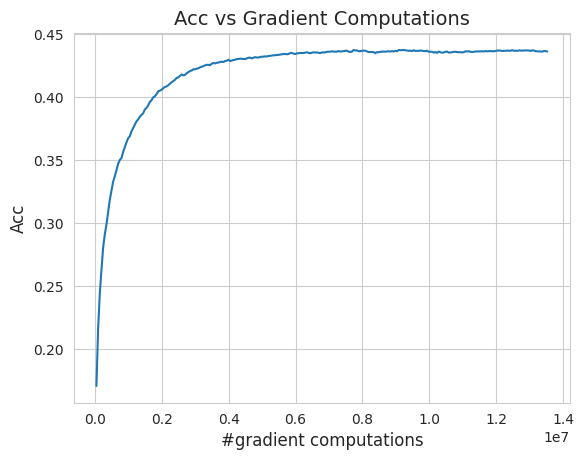

Training: 100%|██████████| 195/195 [00:01<00:00, 111.39it/s, loss=0.0868]


Epoch 272: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 114.16it/s, loss=0.0858]


Epoch 273: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 112.93it/s, loss=0.0850]


Epoch 274: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 111.63it/s, loss=0.0841]


Epoch 275: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 115.74it/s, loss=0.0831]


Epoch 276: val_acc=0.43609777092933655


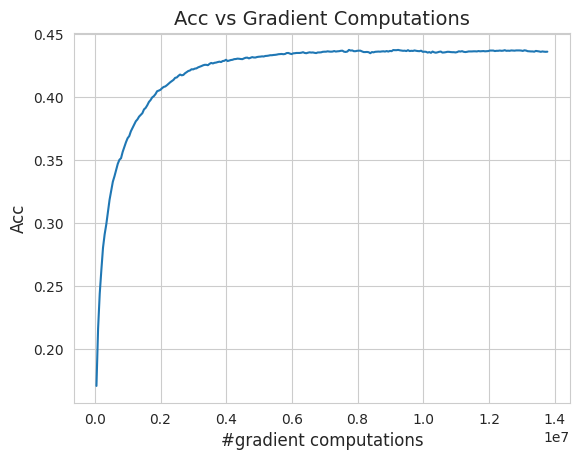

Training: 100%|██████████| 195/195 [00:01<00:00, 110.35it/s, loss=0.0823]


Epoch 277: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 111.36it/s, loss=0.0815]


Epoch 278: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 114.46it/s, loss=0.0806]


Epoch 279: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 109.96it/s, loss=0.0799]


Epoch 280: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 114.49it/s, loss=0.0789]


Epoch 281: val_acc=0.43539664149284363


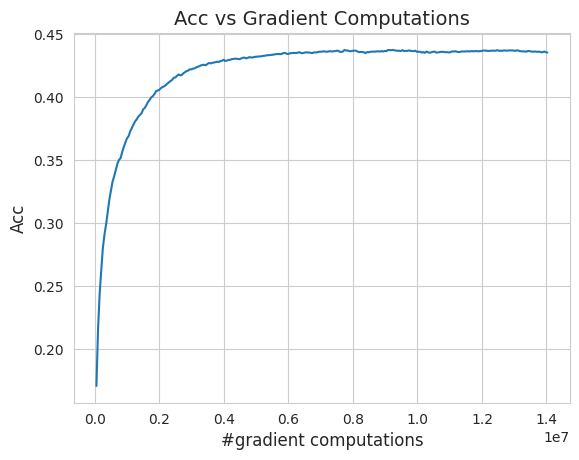

Training: 100%|██████████| 195/195 [00:01<00:00, 112.18it/s, loss=0.0780]


Epoch 282: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 119.06it/s, loss=0.0773]


Epoch 283: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.76it/s, loss=0.0765]


Epoch 284: val_acc=0.43589743971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 111.35it/s, loss=0.0758]


Epoch 285: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 111.49it/s, loss=0.0749]


Epoch 286: val_acc=0.43549680709838867


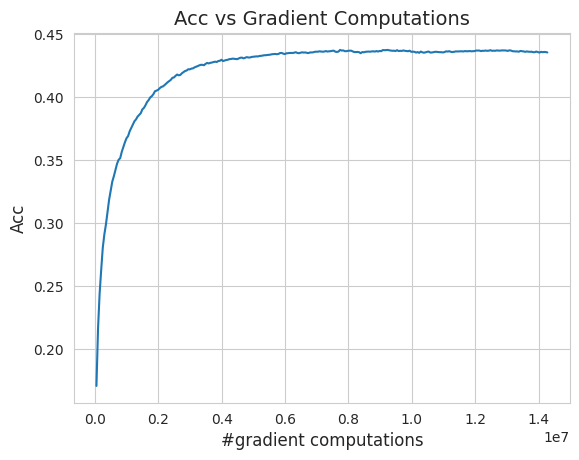

Training: 100%|██████████| 195/195 [00:01<00:00, 109.41it/s, loss=0.0741]


Epoch 287: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 111.79it/s, loss=0.0734]


Epoch 288: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 116.57it/s, loss=0.0726]


Epoch 289: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.13it/s, loss=0.0719]


Epoch 290: val_acc=0.43589743971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 109.58it/s, loss=0.0712]


Epoch 291: val_acc=0.43569710850715637


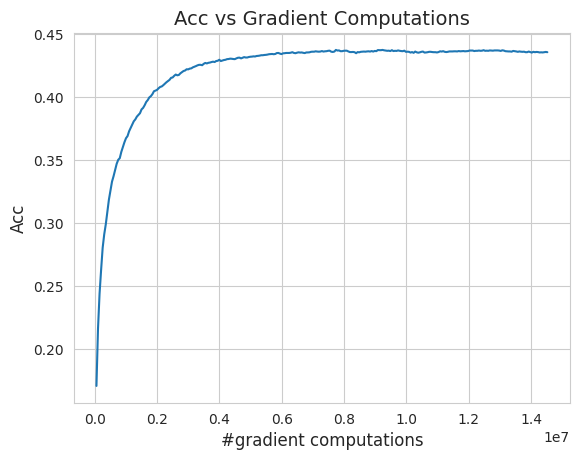

Training: 100%|██████████| 195/195 [00:01<00:00, 113.89it/s, loss=0.0705]


Epoch 292: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 113.43it/s, loss=0.0697]


Epoch 293: val_acc=0.43589743971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 111.39it/s, loss=0.0691]


Epoch 294: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 115.98it/s, loss=0.0683]


Epoch 295: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 112.39it/s, loss=0.0677]


Epoch 296: val_acc=0.4361979365348816


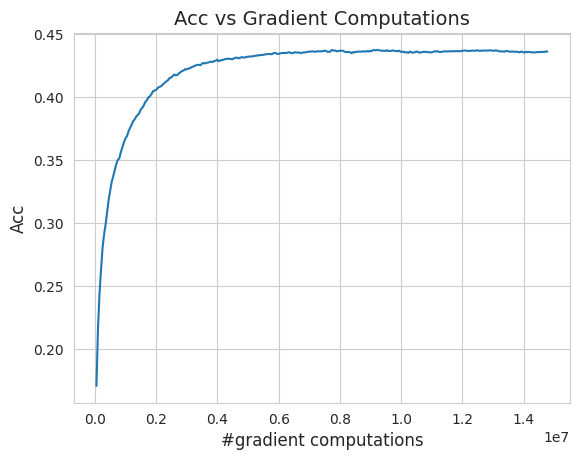

Training: 100%|██████████| 195/195 [00:01<00:00, 110.48it/s, loss=0.0671]


Epoch 297: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 111.74it/s, loss=0.0664]


Epoch 298: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 112.85it/s, loss=0.0659]


Epoch 299: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 114.52it/s, loss=0.0652]


Epoch 300: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 115.60it/s, loss=0.0646]


Epoch 301: val_acc=0.43549680709838867


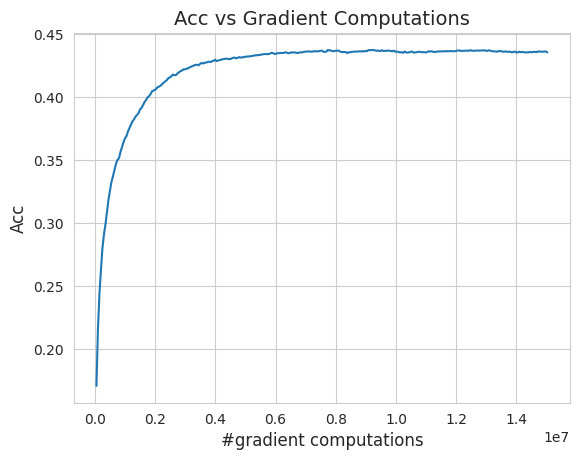

Training: 100%|██████████| 195/195 [00:01<00:00, 111.21it/s, loss=0.0640]


Epoch 302: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.46it/s, loss=0.0634]


Epoch 303: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 113.14it/s, loss=0.0628]


Epoch 304: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 114.90it/s, loss=0.0622]


Epoch 305: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 110.55it/s, loss=0.0616]


Epoch 306: val_acc=0.4363982379436493


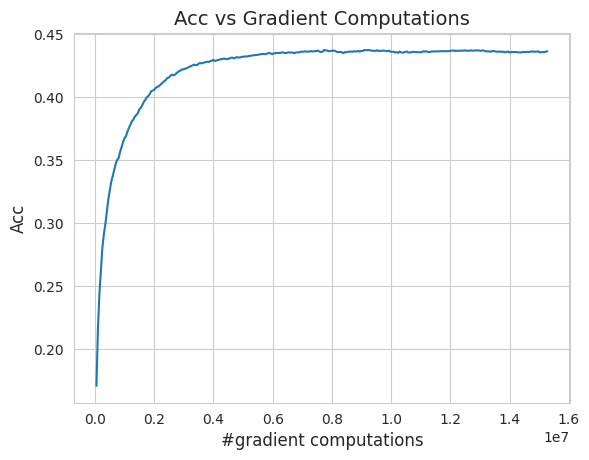

Training: 100%|██████████| 195/195 [00:01<00:00, 111.06it/s, loss=0.0611]


Epoch 307: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 114.70it/s, loss=0.0604]


Epoch 308: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 111.32it/s, loss=0.0600]


Epoch 309: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 118.06it/s, loss=0.0593]


Epoch 310: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 110.80it/s, loss=0.0588]


Epoch 311: val_acc=0.4357972741127014


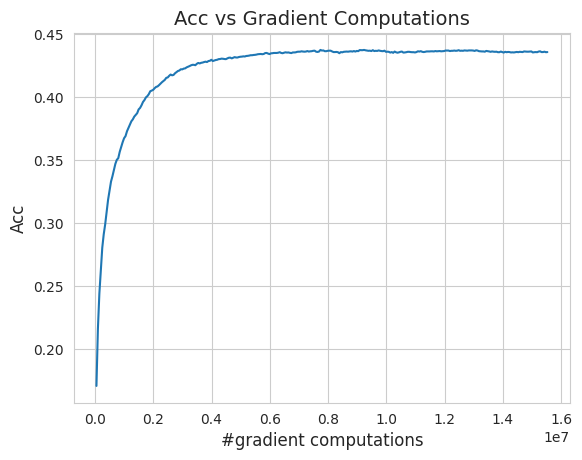

Training: 100%|██████████| 195/195 [00:01<00:00, 110.38it/s, loss=0.0583]


Epoch 312: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.60it/s, loss=0.0578]


Epoch 313: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 116.95it/s, loss=0.0573]


Epoch 314: val_acc=0.4367988705635071


Training: 100%|██████████| 195/195 [00:01<00:00, 114.32it/s, loss=0.0567]


Epoch 315: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 111.56it/s, loss=0.0562]


Epoch 316: val_acc=0.4361979365348816


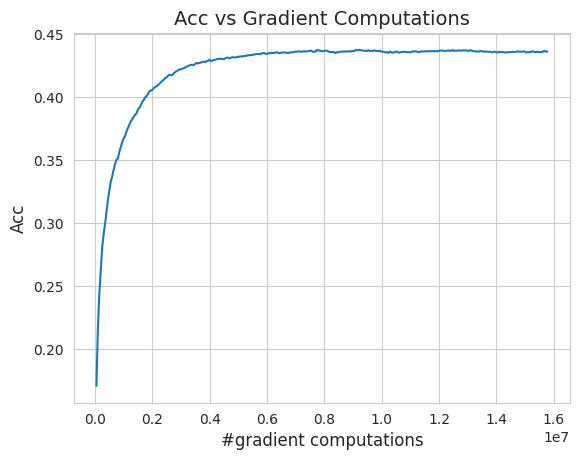

Training: 100%|██████████| 195/195 [00:01<00:00, 111.59it/s, loss=0.0558]


Epoch 317: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 111.45it/s, loss=0.0553]


Epoch 318: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 114.27it/s, loss=0.0548]


Epoch 319: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 113.43it/s, loss=0.0543]


Epoch 320: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 113.61it/s, loss=0.0539]


Epoch 321: val_acc=0.43569710850715637


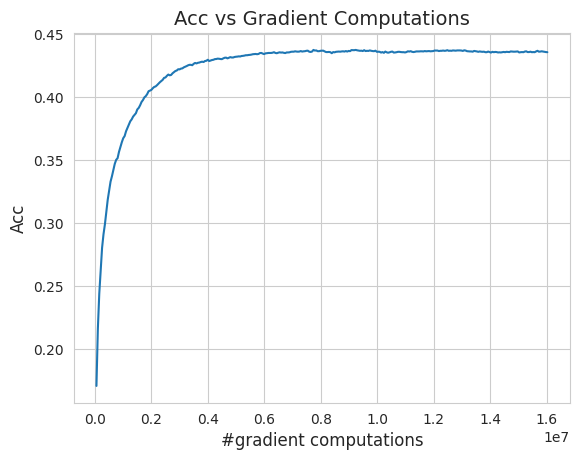

Training: 100%|██████████| 195/195 [00:01<00:00, 111.09it/s, loss=0.0534]


Epoch 322: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 114.49it/s, loss=0.0530]


Epoch 323: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 113.07it/s, loss=0.0525]


Epoch 324: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 112.77it/s, loss=0.0520]


Epoch 325: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 111.90it/s, loss=0.0516]


Epoch 326: val_acc=0.43569710850715637


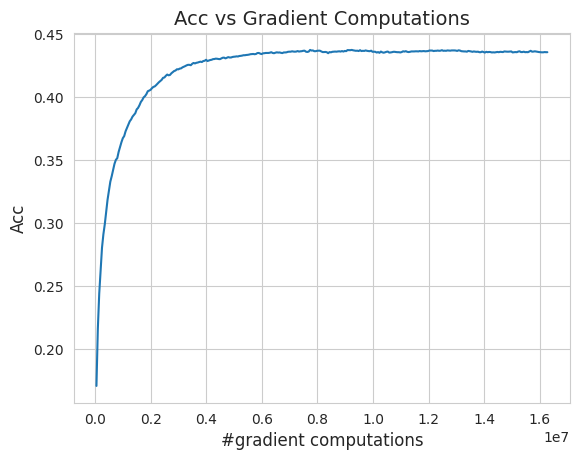

Training: 100%|██████████| 195/195 [00:01<00:00, 118.65it/s, loss=0.0512]


Epoch 327: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.14it/s, loss=0.0507]


Epoch 328: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 112.90it/s, loss=0.0503]


Epoch 329: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 111.58it/s, loss=0.0499]


Epoch 330: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 113.82it/s, loss=0.0495]


Epoch 331: val_acc=0.43519631028175354


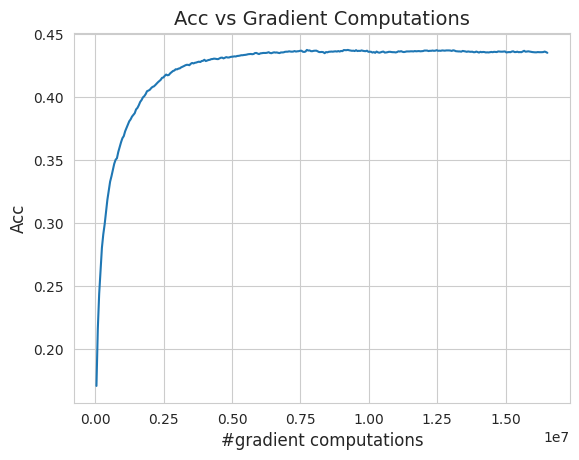

Training: 100%|██████████| 195/195 [00:01<00:00, 111.80it/s, loss=0.0491]


Epoch 332: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 115.81it/s, loss=0.0487]


Epoch 333: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 114.03it/s, loss=0.0483]


Epoch 334: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 114.04it/s, loss=0.0479]


Epoch 335: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.82it/s, loss=0.0475]


Epoch 336: val_acc=0.4357972741127014


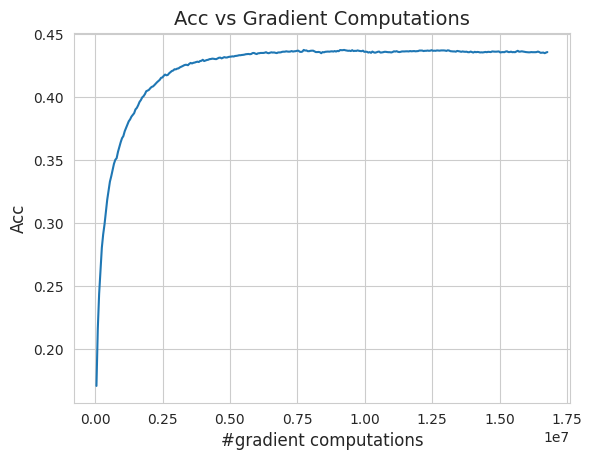

Training: 100%|██████████| 195/195 [00:01<00:00, 118.35it/s, loss=0.0471]


Epoch 337: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 115.15it/s, loss=0.0467]


Epoch 338: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 111.22it/s, loss=0.0464]


Epoch 339: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 112.41it/s, loss=0.0461]


Epoch 340: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 113.49it/s, loss=0.0457]


Epoch 341: val_acc=0.4352964758872986


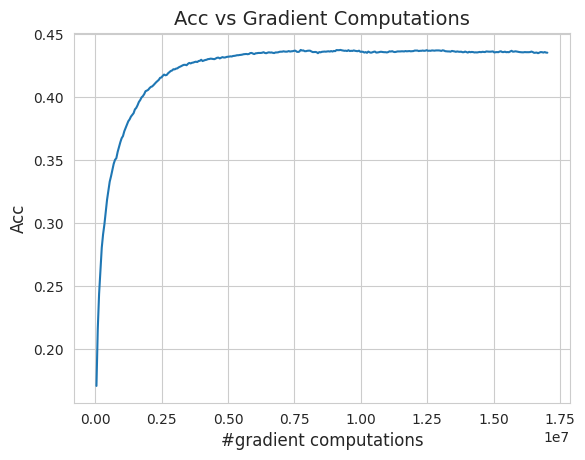

Training: 100%|██████████| 195/195 [00:01<00:00, 112.96it/s, loss=0.0453]


Epoch 342: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 113.38it/s, loss=0.0449]


Epoch 343: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 112.51it/s, loss=0.0446]


Epoch 344: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 111.40it/s, loss=0.0443]


Epoch 345: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 114.84it/s, loss=0.0439]


Epoch 346: val_acc=0.4355969727039337


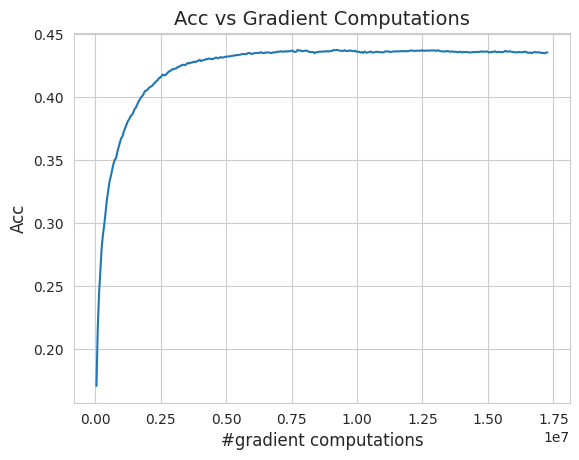

Training: 100%|██████████| 195/195 [00:01<00:00, 115.22it/s, loss=0.0436]


Epoch 347: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.25it/s, loss=0.0433]


Epoch 348: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 109.74it/s, loss=0.0429]


Epoch 349: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 112.02it/s, loss=0.0426]


Epoch 350: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 117.15it/s, loss=0.0423]


Epoch 351: val_acc=0.43519631028175354


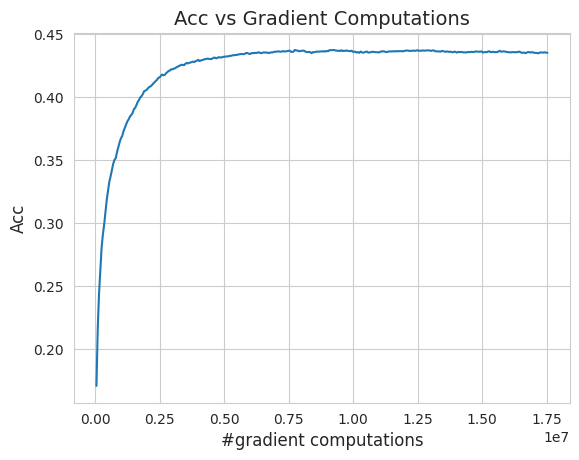

Training: 100%|██████████| 195/195 [00:01<00:00, 113.02it/s, loss=0.0420]


Epoch 352: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 111.49it/s, loss=0.0417]


Epoch 353: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 109.63it/s, loss=0.0414]


Epoch 354: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 111.03it/s, loss=0.0410]


Epoch 355: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.05it/s, loss=0.0408]


Epoch 356: val_acc=0.4350961446762085


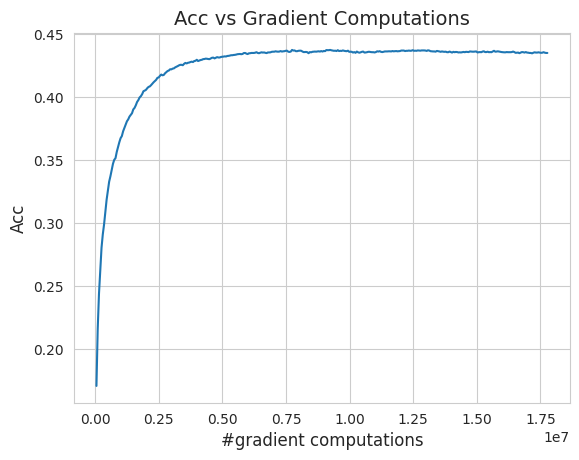

Training: 100%|██████████| 195/195 [00:01<00:00, 110.74it/s, loss=0.0404]


Epoch 357: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 112.16it/s, loss=0.0402]


Epoch 358: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 110.06it/s, loss=0.0399]


Epoch 359: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 110.78it/s, loss=0.0396]


Epoch 360: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 110.57it/s, loss=0.0393]


Epoch 361: val_acc=0.43549680709838867


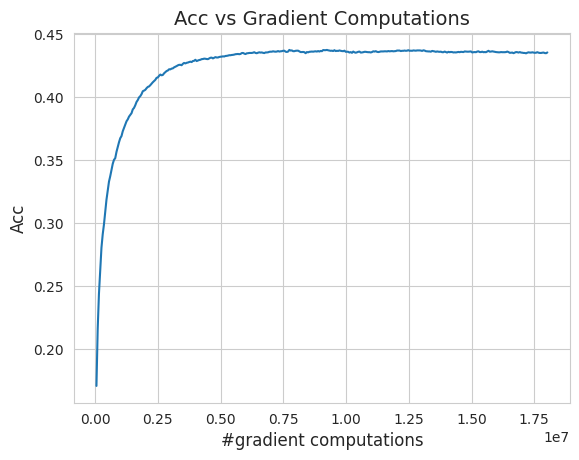

Training: 100%|██████████| 195/195 [00:01<00:00, 112.94it/s, loss=0.0390]


Epoch 362: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 110.08it/s, loss=0.0387]


Epoch 363: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 112.48it/s, loss=0.0384]


Epoch 364: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 112.37it/s, loss=0.0381]


Epoch 365: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 115.02it/s, loss=0.0379]


Epoch 366: val_acc=0.43479567766189575


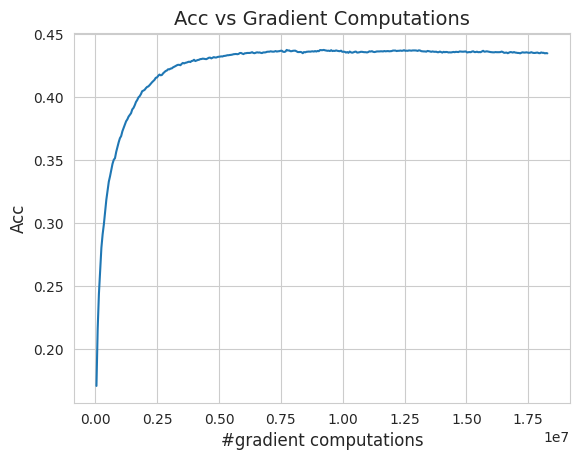

Training: 100%|██████████| 195/195 [00:01<00:00, 111.45it/s, loss=0.0377]


Epoch 367: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 111.64it/s, loss=0.0374]


Epoch 368: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 109.65it/s, loss=0.0372]


Epoch 369: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 110.24it/s, loss=0.0369]


Epoch 370: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 118.64it/s, loss=0.0366]


Epoch 371: val_acc=0.4352964758872986


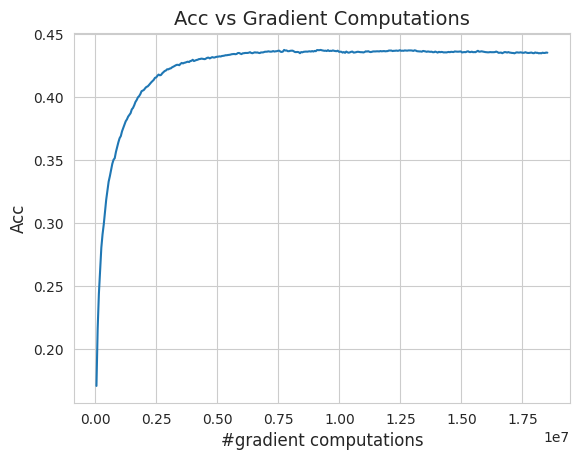

Training: 100%|██████████| 195/195 [00:01<00:00, 108.87it/s, loss=0.0364]


Epoch 372: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 114.15it/s, loss=0.0361]


Epoch 373: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 112.46it/s, loss=0.0358]


Epoch 374: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 109.74it/s, loss=0.0356]


Epoch 375: val_acc=0.4346955120563507


Training: 100%|██████████| 195/195 [00:01<00:00, 113.31it/s, loss=0.0354]


Epoch 376: val_acc=0.4348958432674408


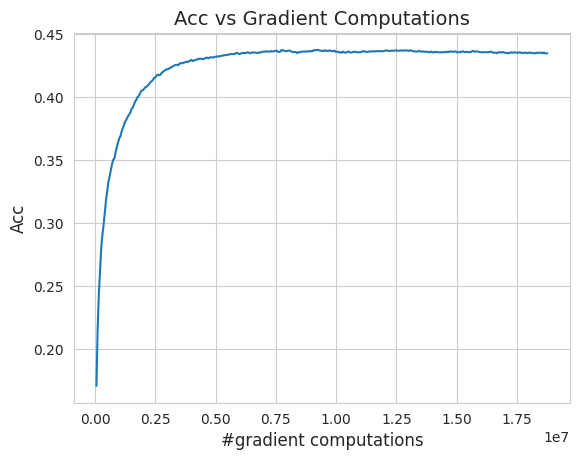

Training: 100%|██████████| 195/195 [00:01<00:00, 115.79it/s, loss=0.0352]


Epoch 377: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 110.52it/s, loss=0.0349]


Epoch 378: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 109.53it/s, loss=0.0347]


Epoch 379: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 112.17it/s, loss=0.0344]


Epoch 380: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 112.81it/s, loss=0.0342]


Epoch 381: val_acc=0.43459534645080566


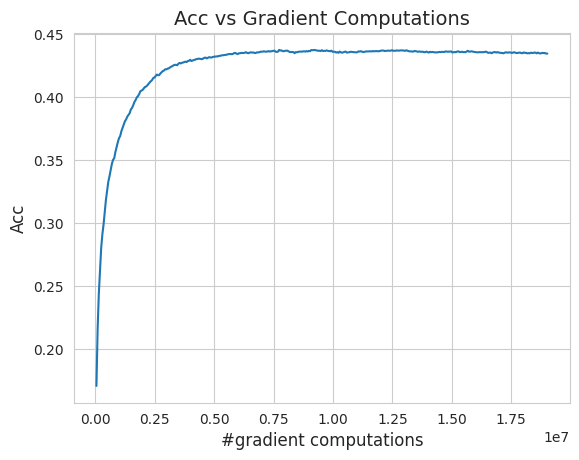

Training: 100%|██████████| 195/195 [00:01<00:00, 113.51it/s, loss=0.0340]


Epoch 382: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 113.48it/s, loss=0.0338]


Epoch 383: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 111.24it/s, loss=0.0335]


Epoch 384: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 109.57it/s, loss=0.0333]


Epoch 385: val_acc=0.43439504504203796


Training: 100%|██████████| 195/195 [00:01<00:00, 111.07it/s, loss=0.0331]


Epoch 386: val_acc=0.43459534645080566


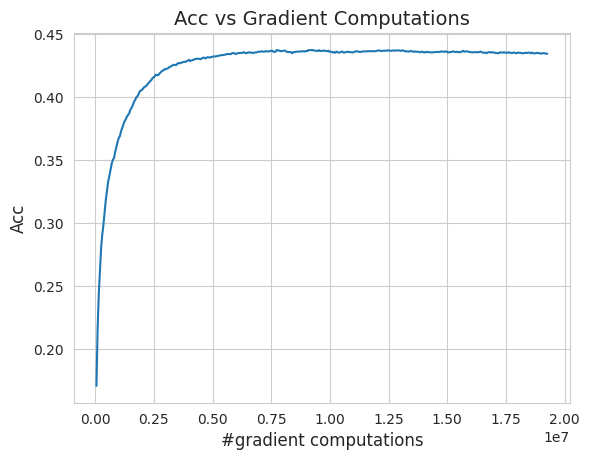

Training: 100%|██████████| 195/195 [00:01<00:00, 111.80it/s, loss=0.0329]


Epoch 387: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 108.69it/s, loss=0.0326]


Epoch 388: val_acc=0.434495210647583


Training: 100%|██████████| 195/195 [00:01<00:00, 116.69it/s, loss=0.0324]


Epoch 389: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 111.47it/s, loss=0.0323]


Epoch 390: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 112.61it/s, loss=0.0321]


Epoch 391: val_acc=0.4348958432674408


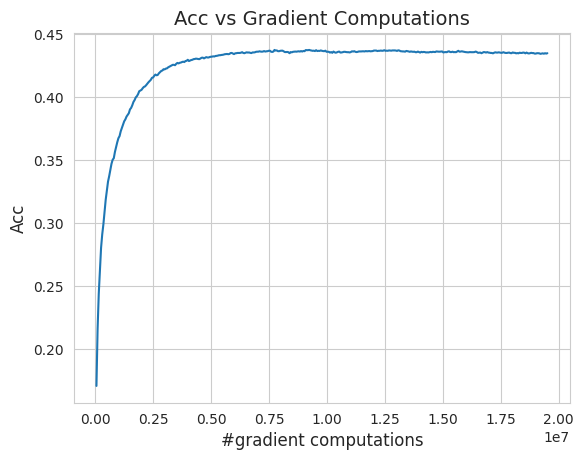

Training: 100%|██████████| 195/195 [00:01<00:00, 113.91it/s, loss=0.0318]


Epoch 392: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 110.09it/s, loss=0.0316]


Epoch 393: val_acc=0.4346955120563507


Training: 100%|██████████| 195/195 [00:01<00:00, 113.24it/s, loss=0.0315]


Epoch 394: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 109.84it/s, loss=0.0313]


Epoch 395: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 115.77it/s, loss=0.0311]


Epoch 396: val_acc=0.43479567766189575


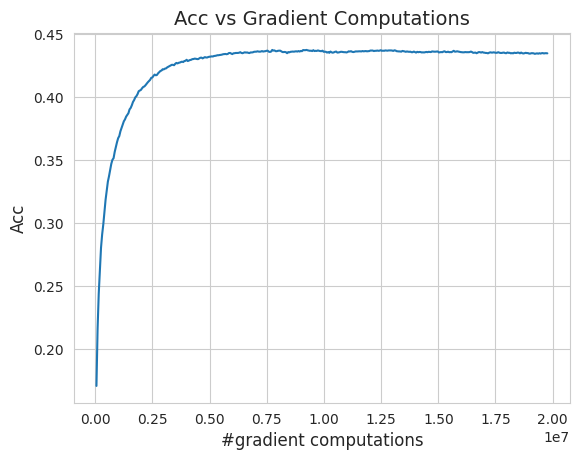

Training: 100%|██████████| 195/195 [00:01<00:00, 113.00it/s, loss=0.0309]


Epoch 397: val_acc=0.434495210647583


Training: 100%|██████████| 195/195 [00:01<00:00, 114.87it/s, loss=0.0307]


Epoch 398: val_acc=0.4342948794364929


Training: 100%|██████████| 195/195 [00:01<00:00, 109.86it/s, loss=0.0305]


Epoch 399: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.17it/s, loss=0.0303]


Epoch 400: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 111.63it/s, loss=0.0301]


Epoch 401: val_acc=0.4348958432674408


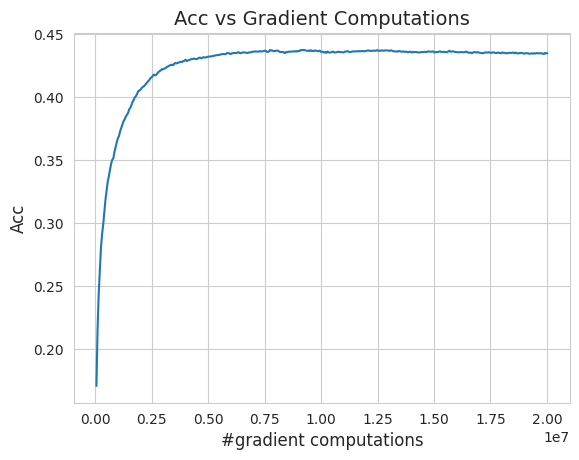

Training: 100%|██████████| 195/195 [00:01<00:00, 114.60it/s, loss=0.0299]


Epoch 402: val_acc=0.434495210647583


Training: 100%|██████████| 195/195 [00:01<00:00, 113.31it/s, loss=0.0298]


Epoch 403: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.05it/s, loss=0.0295]


Epoch 404: val_acc=0.4346955120563507


Training: 100%|██████████| 195/195 [00:01<00:00, 111.91it/s, loss=0.0294]


Epoch 405: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 110.78it/s, loss=0.0293]


Epoch 406: val_acc=0.43499600887298584


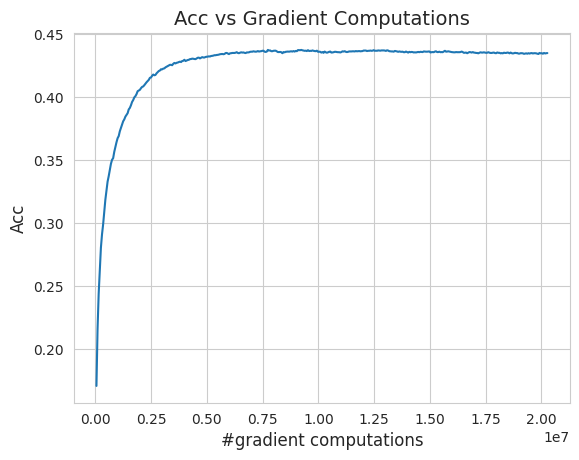

Training: 100%|██████████| 195/195 [00:01<00:00, 113.17it/s, loss=0.0290]


Epoch 407: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 120.13it/s, loss=0.0288]


Epoch 408: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 111.50it/s, loss=0.0287]


Epoch 409: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 110.84it/s, loss=0.0285]


Epoch 410: val_acc=0.43459534645080566


Training: 100%|██████████| 195/195 [00:01<00:00, 111.97it/s, loss=0.0284]


Epoch 411: val_acc=0.4346955120563507


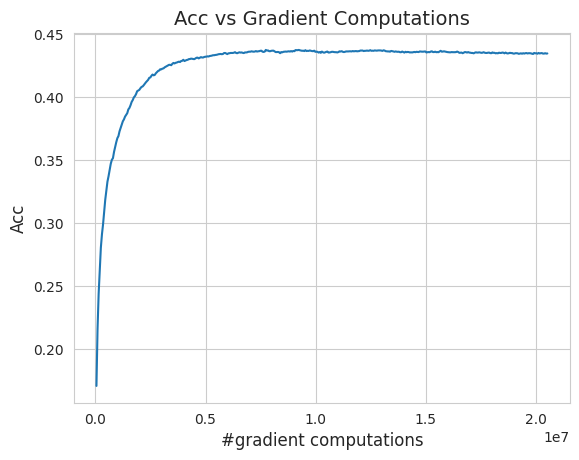

Training: 100%|██████████| 195/195 [00:01<00:00, 114.87it/s, loss=0.0282]


Epoch 412: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 113.80it/s, loss=0.0280]


Epoch 413: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 112.95it/s, loss=0.0279]


Epoch 414: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 113.23it/s, loss=0.0277]


Epoch 415: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 114.47it/s, loss=0.0276]


Epoch 416: val_acc=0.4350961446762085


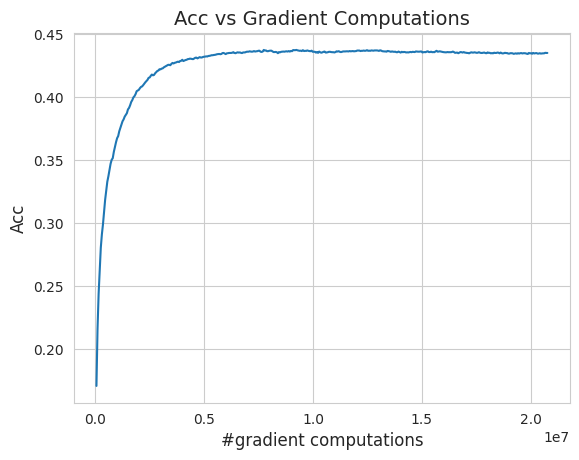

Training: 100%|██████████| 195/195 [00:01<00:00, 113.58it/s, loss=0.0274]


Epoch 417: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 112.36it/s, loss=0.0272]


Epoch 418: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 110.60it/s, loss=0.0271]


Epoch 419: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 113.80it/s, loss=0.0270]


Epoch 420: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 114.97it/s, loss=0.0268]


Epoch 421: val_acc=0.43479567766189575


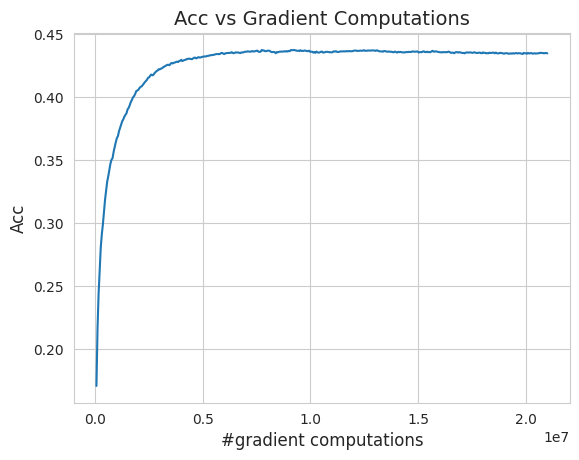

Training: 100%|██████████| 195/195 [00:01<00:00, 115.90it/s, loss=0.0266]


Epoch 422: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.64it/s, loss=0.0265]


Epoch 423: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 113.31it/s, loss=0.0263]


Epoch 424: val_acc=0.43479567766189575


Training: 100%|██████████| 195/195 [00:01<00:00, 111.21it/s, loss=0.0262]


Epoch 425: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 111.89it/s, loss=0.0260]


Epoch 426: val_acc=0.4355969727039337


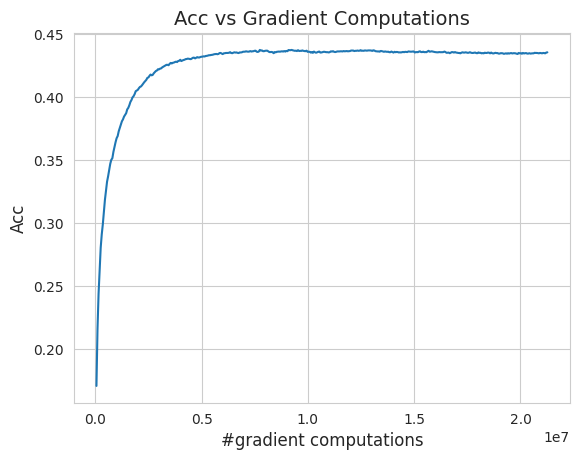

Training: 100%|██████████| 195/195 [00:01<00:00, 112.63it/s, loss=0.0259]


Epoch 427: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 113.14it/s, loss=0.0257]


Epoch 428: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 108.84it/s, loss=0.0256]


Epoch 429: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 110.17it/s, loss=0.0254]


Epoch 430: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 112.92it/s, loss=0.0253]


Epoch 431: val_acc=0.43499600887298584


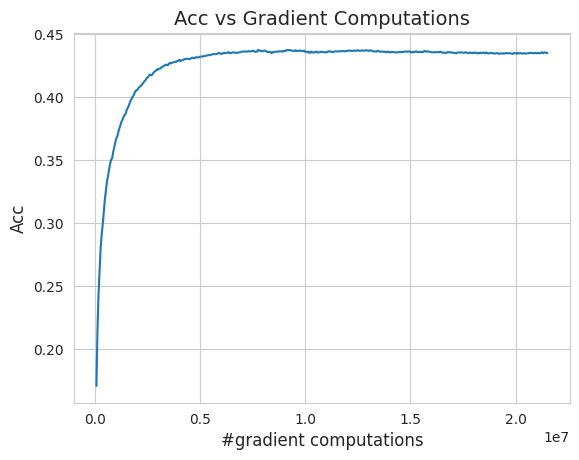

Training: 100%|██████████| 195/195 [00:01<00:00, 112.22it/s, loss=0.0252]


Epoch 432: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 114.79it/s, loss=0.0250]


Epoch 433: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 113.59it/s, loss=0.0249]


Epoch 434: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 113.99it/s, loss=0.0248]


Epoch 435: val_acc=0.43539664149284363


Training: 100%|██████████| 195/195 [00:01<00:00, 113.78it/s, loss=0.0246]


Epoch 436: val_acc=0.43519631028175354


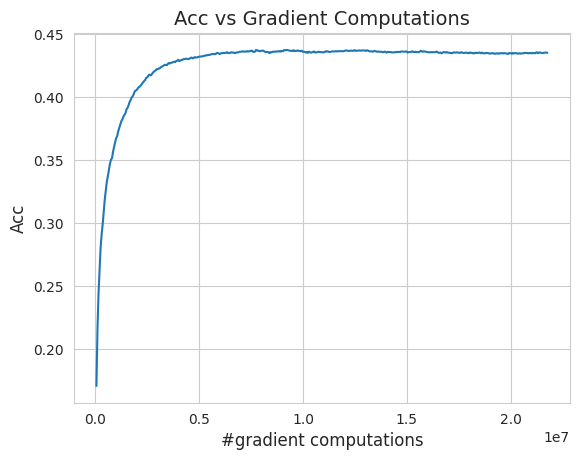

Training: 100%|██████████| 195/195 [00:01<00:00, 112.50it/s, loss=0.0245]


Epoch 437: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 114.75it/s, loss=0.0243]


Epoch 438: val_acc=0.43499600887298584


Training: 100%|██████████| 195/195 [00:01<00:00, 108.16it/s, loss=0.0242]


Epoch 439: val_acc=0.43519631028175354


Training: 100%|██████████| 195/195 [00:01<00:00, 114.23it/s, loss=0.0241]


Epoch 440: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 112.95it/s, loss=0.0240]


Epoch 441: val_acc=0.43519631028175354


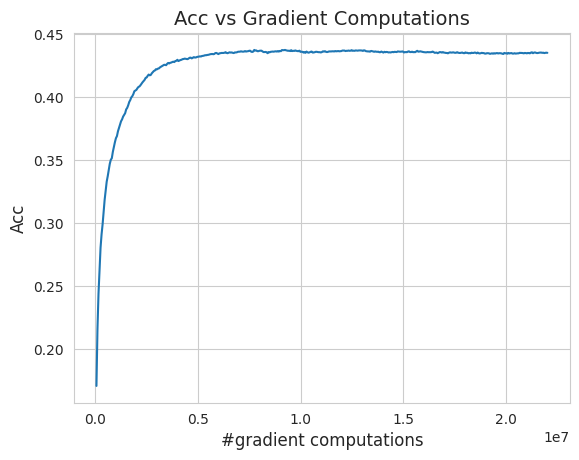

Training: 100%|██████████| 195/195 [00:01<00:00, 111.80it/s, loss=0.0239]


Epoch 442: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.26it/s, loss=0.0237]


Epoch 443: val_acc=0.4348958432674408


Training: 100%|██████████| 195/195 [00:01<00:00, 110.05it/s, loss=0.0236]


Epoch 444: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 112.69it/s, loss=0.0235]


Epoch 445: val_acc=0.4352964758872986


Training: 100%|██████████| 195/195 [00:01<00:00, 117.28it/s, loss=0.0234]


Epoch 446: val_acc=0.4355969727039337


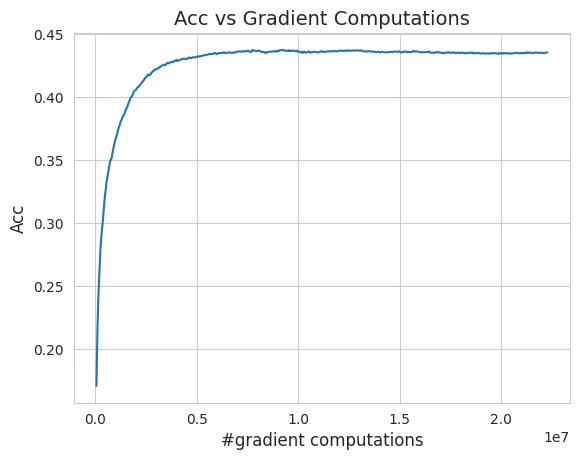

Training: 100%|██████████| 195/195 [00:01<00:00, 109.70it/s, loss=0.0232]


Epoch 447: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 115.06it/s, loss=0.0231]


Epoch 448: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 110.80it/s, loss=0.0230]


Epoch 449: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 113.94it/s, loss=0.0229]


Epoch 450: val_acc=0.4350961446762085


Training: 100%|██████████| 195/195 [00:01<00:00, 111.29it/s, loss=0.0228]


Epoch 451: val_acc=0.43539664149284363


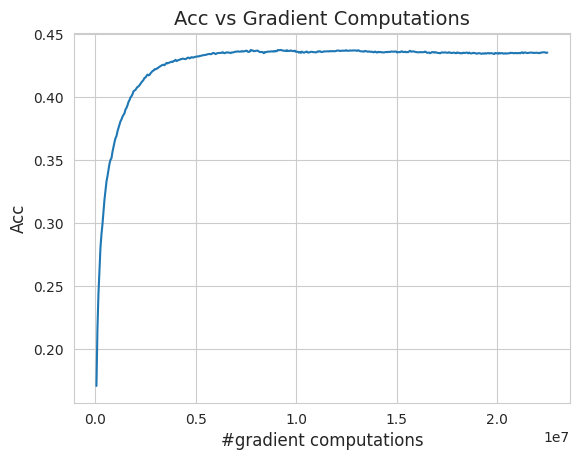

Training: 100%|██████████| 195/195 [00:01<00:00, 112.89it/s, loss=0.0227]


Epoch 452: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 115.56it/s, loss=0.0226]


Epoch 453: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 109.78it/s, loss=0.0224]


Epoch 454: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 113.75it/s, loss=0.0223]


Epoch 455: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 113.98it/s, loss=0.0222]


Epoch 456: val_acc=0.4355969727039337


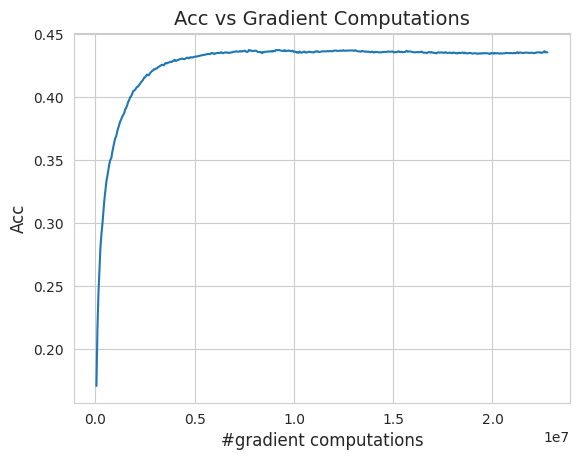

Training: 100%|██████████| 195/195 [00:01<00:00, 113.18it/s, loss=0.0221]


Epoch 457: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 112.55it/s, loss=0.0220]


Epoch 458: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 118.02it/s, loss=0.0219]


Epoch 459: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 110.05it/s, loss=0.0218]


Epoch 460: val_acc=0.43549680709838867


Training: 100%|██████████| 195/195 [00:01<00:00, 114.30it/s, loss=0.0217]


Epoch 461: val_acc=0.4357972741127014


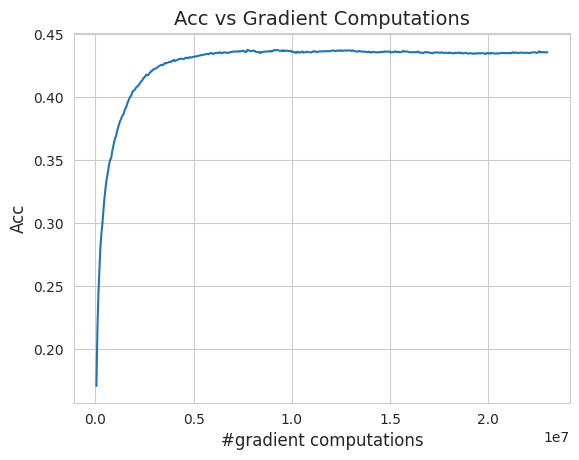

Training: 100%|██████████| 195/195 [00:01<00:00, 113.43it/s, loss=0.0216]


Epoch 462: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 109.25it/s, loss=0.0214]


Epoch 463: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 113.91it/s, loss=0.0213]


Epoch 464: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 122.56it/s, loss=0.0212]


Epoch 465: val_acc=0.4357972741127014


Training: 100%|██████████| 195/195 [00:01<00:00, 110.60it/s, loss=0.0211]


Epoch 466: val_acc=0.43569710850715637


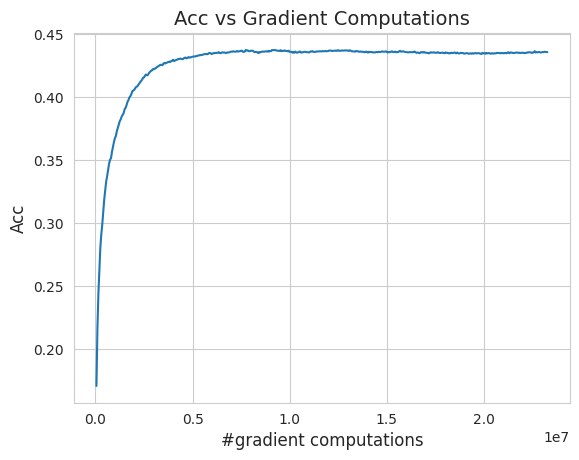

Training: 100%|██████████| 195/195 [00:01<00:00, 110.62it/s, loss=0.0210]


Epoch 467: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 110.94it/s, loss=0.0209]


Epoch 468: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 117.01it/s, loss=0.0208]


Epoch 469: val_acc=0.4359976053237915


Training: 100%|██████████| 195/195 [00:01<00:00, 113.34it/s, loss=0.0207]


Epoch 470: val_acc=0.43569710850715637


Training: 100%|██████████| 195/195 [00:01<00:00, 109.35it/s, loss=0.0206]


Epoch 471: val_acc=0.43569710850715637


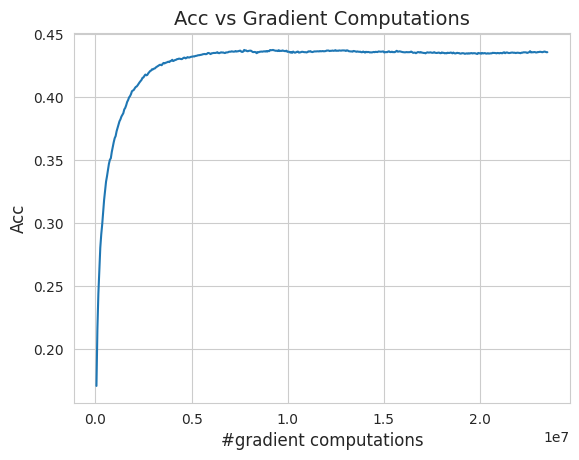

Training: 100%|██████████| 195/195 [00:01<00:00, 114.89it/s, loss=0.0205]


Epoch 472: val_acc=0.43589743971824646


Training: 100%|██████████| 195/195 [00:01<00:00, 112.16it/s, loss=0.0204]


Epoch 473: val_acc=0.4355969727039337


Training: 100%|██████████| 195/195 [00:01<00:00, 112.75it/s, loss=0.0203]


Epoch 474: val_acc=0.4361979365348816


Training: 100%|██████████| 195/195 [00:01<00:00, 110.86it/s, loss=0.0203]


Epoch 475: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 113.08it/s, loss=0.0202]


Epoch 476: val_acc=0.4361979365348816


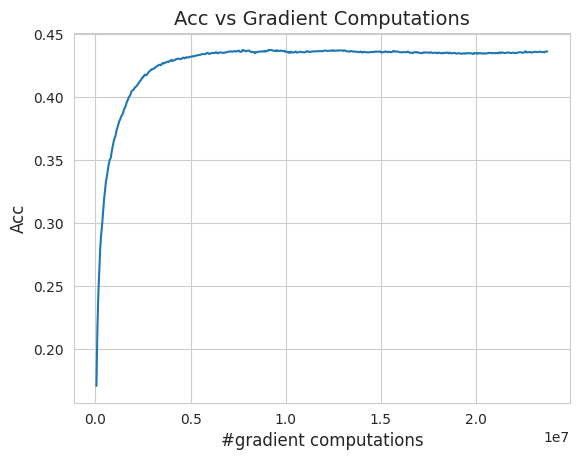

Training: 100%|██████████| 195/195 [00:01<00:00, 115.08it/s, loss=0.0200]


Epoch 477: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 114.31it/s, loss=0.0200]


Epoch 478: val_acc=0.43609777092933655


Training: 100%|██████████| 195/195 [00:01<00:00, 116.91it/s, loss=0.0199]


Epoch 479: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 113.58it/s, loss=0.0198]


Epoch 480: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 113.43it/s, loss=0.0197]


Epoch 481: val_acc=0.4366987347602844


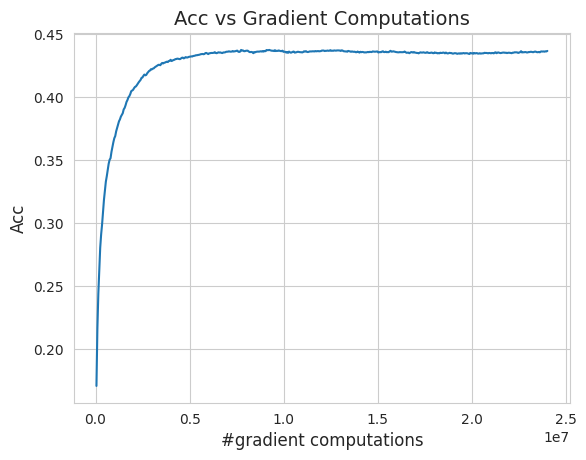

Training: 100%|██████████| 195/195 [00:01<00:00, 115.19it/s, loss=0.0196]


Epoch 482: val_acc=0.4368990361690521


Training: 100%|██████████| 195/195 [00:01<00:00, 112.17it/s, loss=0.0195]


Epoch 483: val_acc=0.4363982379436493


Training: 100%|██████████| 195/195 [00:01<00:00, 114.57it/s, loss=0.0194]


Epoch 484: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 115.72it/s, loss=0.0194]


Epoch 485: val_acc=0.43629807233810425


Training: 100%|██████████| 195/195 [00:01<00:00, 112.89it/s, loss=0.0193]


Epoch 486: val_acc=0.4370993673801422


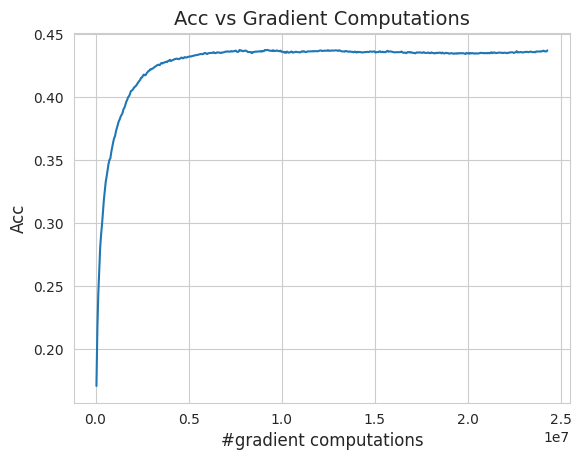

Training: 100%|██████████| 195/195 [00:01<00:00, 112.63it/s, loss=0.0192]


Epoch 487: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 113.20it/s, loss=0.0191]


Epoch 488: val_acc=0.4366987347602844


Training: 100%|██████████| 195/195 [00:01<00:00, 110.24it/s, loss=0.0190]


Epoch 489: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 113.04it/s, loss=0.0189]


Epoch 490: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 114.39it/s, loss=0.0188]


Epoch 491: val_acc=0.43649840354919434


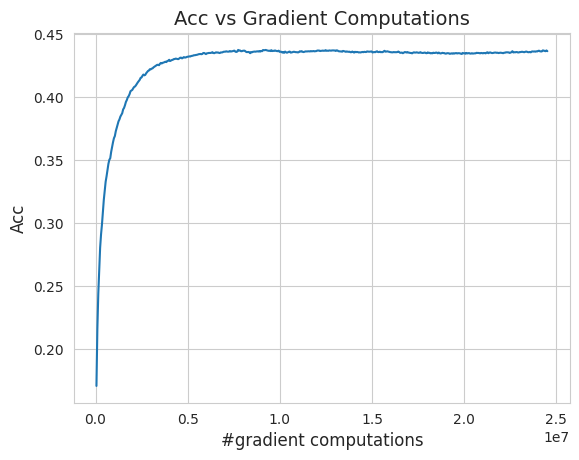

Training: 100%|██████████| 195/195 [00:01<00:00, 112.52it/s, loss=0.0187]


Epoch 492: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 117.18it/s, loss=0.0187]


Epoch 493: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 112.13it/s, loss=0.0186]


Epoch 494: val_acc=0.4370993673801422


Training: 100%|██████████| 195/195 [00:01<00:00, 110.00it/s, loss=0.0185]


Epoch 495: val_acc=0.43649840354919434


Training: 100%|██████████| 195/195 [00:01<00:00, 112.52it/s, loss=0.0184]


Epoch 496: val_acc=0.4367988705635071


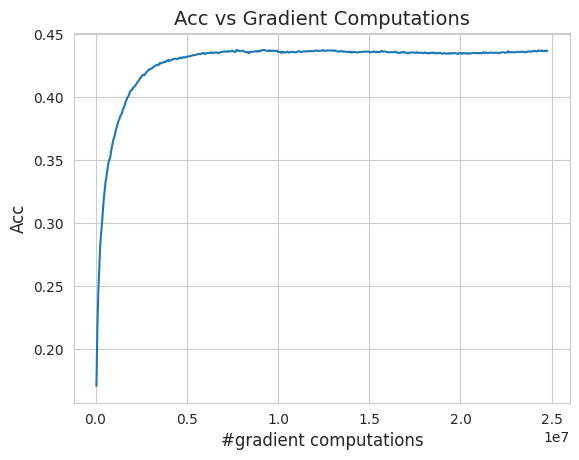

Training: 100%|██████████| 195/195 [00:01<00:00, 114.13it/s, loss=0.0183]


Epoch 497: val_acc=0.4372996985912323


Training: 100%|██████████| 195/195 [00:01<00:00, 111.56it/s, loss=0.0183]


Epoch 498: val_acc=0.4365985691547394


Training: 100%|██████████| 195/195 [00:01<00:00, 112.05it/s, loss=0.0182]


Epoch 499: val_acc=0.43699920177459717


Training: 100%|██████████| 195/195 [00:01<00:00, 110.96it/s, loss=0.0181]


Epoch 500: val_acc=0.4367988705635071


In [9]:
rng = jax.random.PRNGKey(42)
bs = 256
bs_hat = 16

train_loader, val_loader = get_cifar10_dataloaders(batch_size=bs, with_augmentation=False, shuffle=False)
init_batch = tf_to_jax(next(iter(train_loader)))
resnet18, variables = init_model(rng, init_batch)

compute_accuracy = jax.jit(get_compute_accuracy_fn(resnet18))

train_loss_fn = get_cross_entropy_loss_fn(resnet18, train=True)
eval_loss_fn = get_cross_entropy_loss_fn(resnet18, train=False)
optimizer = SGD(train_loss_fn,
                lr=1e-4,
                need_jit=True)

state = optimizer.init(variables)
# optimizer = PAGE(loss_fn=train_loss_fn,
#                 eval_loss_fn=eval_loss_fn,
#                 p=bs_hat/(bs+bs_hat),
#                 lr=1e-4,
#                 bs=bs,
#                 bs_hat=bs_hat,
#                 need_jit=True)

acc_arr, grad_count, state = train(state=state,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=500,
            compute_accuracy=compute_accuracy)

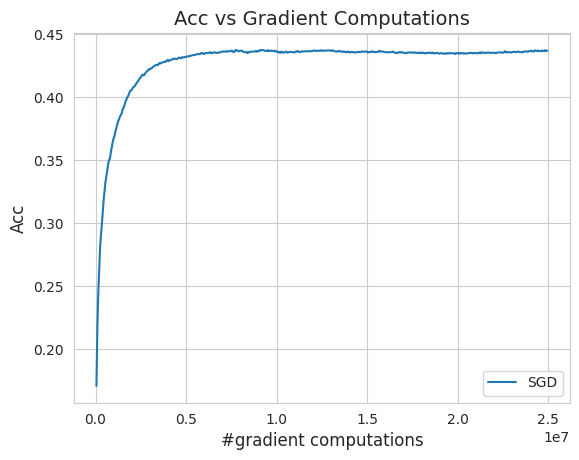

In [13]:
plt.plot(grad_count, acc_arr, label="SGD")
plt.xlabel('#gradient computations', fontsize=12)
plt.ylabel('Acc', fontsize=12)
plt.title('Acc vs Gradient Computations', fontsize=14)
plt.legend()
plt.savefig("acc_vs_grad_sgd.png")
plt.show()

In [17]:
", ".join(map(str, grad_count))

'49920, 99840, 149760, 199680, 249600, 299520, 349440, 399360, 449280, 499200, 549120, 599040, 648960, 698880, 748800, 798720, 848640, 898560, 948480, 998400, 1048320, 1098240, 1148160, 1198080, 1248000, 1297920, 1347840, 1397760, 1447680, 1497600, 1547520, 1597440, 1647360, 1697280, 1747200, 1797120, 1847040, 1896960, 1946880, 1996800, 2046720, 2096640, 2146560, 2196480, 2246400, 2296320, 2346240, 2396160, 2446080, 2496000, 2545920, 2595840, 2645760, 2695680, 2745600, 2795520, 2845440, 2895360, 2945280, 2995200, 3045120, 3095040, 3144960, 3194880, 3244800, 3294720, 3344640, 3394560, 3444480, 3494400, 3544320, 3594240, 3644160, 3694080, 3744000, 3793920, 3843840, 3893760, 3943680, 3993600, 4043520, 4093440, 4143360, 4193280, 4243200, 4293120, 4343040, 4392960, 4442880, 4492800, 4542720, 4592640, 4642560, 4692480, 4742400, 4792320, 4842240, 4892160, 4942080, 4992000, 5041920, 5091840, 5141760, 5191680, 5241600, 5291520, 5341440, 5391360, 5441280, 5491200, 5541120, 5591040, 5640960, 5690

In [18]:
", ".join(map(str, acc_arr))

'0.17107372, 0.21644631, 0.24419071, 0.263121, 0.28064904, 0.29126602, 0.2991787, 0.3091947, 0.31870994, 0.3258213, 0.33303285, 0.33733976, 0.3422476, 0.34715545, 0.35036057, 0.35166267, 0.35667068, 0.36047676, 0.36428285, 0.367488, 0.36919072, 0.3729968, 0.37560096, 0.37810498, 0.38090947, 0.38241187, 0.3846154, 0.38591748, 0.3873197, 0.39032453, 0.39152646, 0.39362982, 0.39623398, 0.39773637, 0.39983976, 0.40084136, 0.40244392, 0.4047476, 0.4052484, 0.40584937, 0.40715146, 0.40815306, 0.4085537, 0.4095553, 0.4107572, 0.41185898, 0.41286057, 0.41376203, 0.4153646, 0.41566506, 0.41696715, 0.41796875, 0.4173678, 0.41766828, 0.41897035, 0.4198718, 0.42077324, 0.42117387, 0.4221755, 0.42207533, 0.4226763, 0.4228766, 0.4236779, 0.4241787, 0.4246795, 0.42528045, 0.42568108, 0.42568108, 0.42538062, 0.42648238, 0.4271835, 0.42678285, 0.42728364, 0.42748398, 0.4278846, 0.4281851, 0.4278846, 0.4286859, 0.42888623, 0.4296875, 0.4286859, 0.42908654, 0.4294872, 0.4296875, 0.4301883, 0.43028846, 0.